In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import copy

In [2]:
linear_trend = np.linspace(0, 10, 5)

In [3]:
x = np.linspace(0, 10 * np.pi, 10)
increasing_sine_wave = np.sin(x) + 0.1 * x  # Increasing sine wave

In [4]:
exponential_trend = np.exp(np.linspace(0, 2, 13))

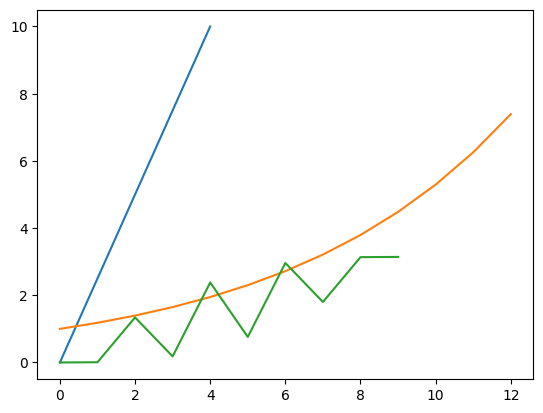

In [5]:
plt.plot(linear_trend)
plt.plot(exponential_trend)
plt.plot(increasing_sine_wave)
# plt.legend(['linear', ''])
plt.show()

In [6]:
print(linear_trend)
print(exponential_trend)
print(increasing_sine_wave)

[ 0.   2.5  5.   7.5 10. ]
[1.         1.18136041 1.39561243 1.64872127 1.94773404 2.30097589
 2.71828183 3.21127054 3.79366789 4.48168907 5.29449005 6.25470095
 7.3890561 ]
[0.         0.00704571 1.34091931 0.18117215 2.38107115 0.7605215
 2.96042051 1.80067334 3.13454695 3.14159265]


In [7]:

# Generate random ages
np.random.seed(42)  # for reproducibility
n_samples = 10000
ages = np.concatenate([
    np.random.normal(60, 10, int(0.8 * n_samples)),  # 80% of the data around age 60
    np.random.normal(30, 10, int(0.2 * n_samples))   # 20% of the data around age 30
])
ages = np.clip(ages, 0, 100)  # Clip ages between 0 and 100


# Function to generate age-independent data
def generate_age_independent_trends(num_sequences, max_length, noise):
    np.random.seed(42)  # for reproducibility
    data = {}

    for patid in tqdm(range(num_sequences)):
        length = np.random.randint(5, max_length)
        trend_type = np.random.choice(['increasing', 'decreasing'])
        x = np.linspace(0, 1, length)
        
        # Generate f(x) with a trend
        if trend_type == 'increasing':
            y = np.polyval(np.polyfit(x, np.random.rand(length) + np.linspace(0, 2, length), 2), x)
        else:
            y = np.polyval(np.polyfit(x, np.random.rand(length) + np.linspace(2, 0, length), 2), x)
        
        # Add some noise
        y += np.random.normal(scale=noise, size=length)
        y = y + np.sin(2 * np.pi * np.random.rand() * x)
        # Store the generated sequence
        data[patid] = {
            'seq': y,
            'age': ages[patid],  # Age is stored but not used in generation
            'label': 1 if trend_type == 'increasing' else 0
        }

    return data
# Generate the age-independent trends data
age_independent_data = generate_age_independent_trends(num_sequences=10000, max_length=50, noise=0.6)



100%|██████████| 10000/10000 [00:01<00:00, 6288.61it/s]


1.9205630081057938


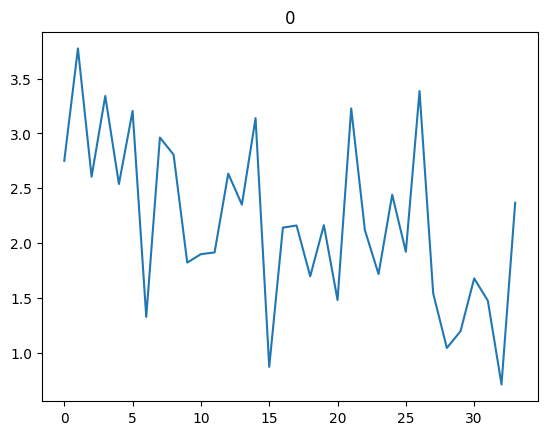

In [8]:
i = 2546
plt.plot(age_independent_data[i]['seq'])
plt.title(age_independent_data[i]['label'])
print(age_independent_data[i]['seq'][25])

In [9]:
with open('datasets_new_scenarios/noise0.6_beta0.pickle','wb') as handle:
    pickle.dump(age_independent_data, handle)

# Trend data with missingness

In [10]:
def calculate_missingness(data):
    # Calculate total values and missing values across all sequences in the data
    total_values = sum(len(values['seq']) for values in data.values())
    missing_values = sum(np.isnan(values['seq']).sum() for values in data.values())
    # Return the overall missing rate
    return missing_values / total_values

### missing completely at random (MCAR)

In [11]:
def introduce_mcar(data, missing_rate=0.3):
    np.random.seed(111)
    for patid, values in data.items():
        seq = values['seq']
        mask = np.random.rand(len(seq)) > missing_rate # if random number is greater than missing_rate, the value will be kept. As the random number is from 0 to 1 there are 1-missing_rate percent chance that the value will be kept
        seq[~mask] = np.nan  # Introducing missing values
        data[patid]['seq'] = seq
    return data

In [12]:
import pickle
with open('datasets_new_scenarios/noise0.6_beta0.pickle','rb') as handle:
    trends_data = pickle.load(handle)

In [13]:
data_miss = introduce_mcar(copy.deepcopy(trends_data))

Text(0.5, 1.0, '0')

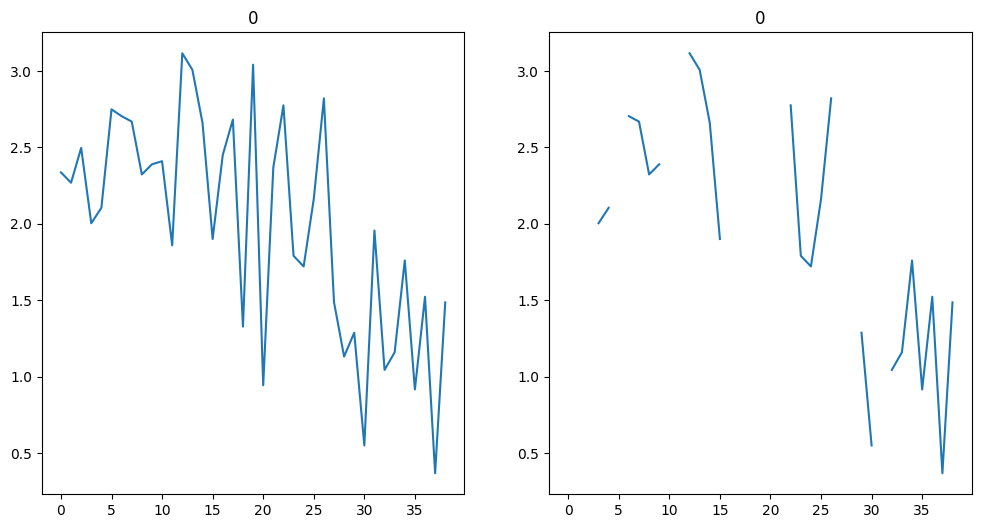

In [14]:
# miss = 0.1
i = 70
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(age_independent_data[i]['seq'])
axes[0].set_title(age_independent_data[i]['label'])

axes[1].plot(data_miss[i]['seq'])
axes[1].set_title(data_miss[i]['label'])

In [15]:
for key, pat_dat in data_miss.items():
    time_stamp = np.where(~np.isnan(pat_dat['seq']))[0]
    pat_dat['timestamps'] = time_stamp
    

In [16]:
with open('datasets_new_scenarios/mcar0.3_beta0.pickle','wb') as handle:
    pickle.dump(data_miss, handle)

In [17]:
with open('datasets_new_scenarios/noise0.6_beta0.pickle','rb') as handle:
    trends_data = pickle.load(handle)
data_miss = introduce_mcar(copy.deepcopy(trends_data), missing_rate=0.6)
for key, pat_dat in data_miss.items():
    time_stamp = np.where(~np.isnan(pat_dat['seq']))[0]
    pat_dat['timestamps'] = time_stamp
with open('datasets_new_scenarios/mcar0.6_beta0.pickle','wb') as handle:
    pickle.dump(data_miss, handle)

In [18]:
max_len = 0
for i, d in data_miss.items():
    if max_len<len(d['seq']):
        max_len = len(d['seq'])
max_len

49

### Missing at random (MAR)

In [19]:
### Missing at random (MAR)

In [20]:
def introduce_mar(data, target_missing_rate=0.3, max_iter=100):
    np.random.seed(111)  # Set seed for reproducibility
    tolerance = 0.01  # Tolerance for reaching the target missing rate

    # Extract sequences and ages into arrays
    original_sequences = [np.array(values['seq']) for values in data.values()]
    ages = np.array([float(values['age']) for values in data.values()])

    # Normalize ages
    normalized_ages = (ages - ages.min()) / (ages.max() - ages.min())

    # Initial missing rates for the two groups
    missing_rate_below_50 = target_missing_rate * 0.5  # Start with half of the target for below 50
    missing_rate_above_50 = target_missing_rate * 1.5  # Start with 1.5x the target for above 50

    for iteration in range(max_iter):
        # Reset sequences to original before each iteration to avoid cumulative missingness
        sequences = [seq.copy() for seq in original_sequences]
        
        # Introduce missing values based on age groups
        for i, seq in enumerate(sequences):
            if ages[i] > 50:
                # Apply higher missing rate for patients above 50
                mask = np.random.rand(len(seq)) > missing_rate_above_50
            else:
                # Apply lower missing rate for patients 50 or below
                mask = np.random.rand(len(seq)) > missing_rate_below_50
            
            seq[~mask] = np.nan  # Set values to NaN based on the mask
            
            # Replace the last value with the normalized age
            seq[-1] = normalized_ages[i]
        
        # Update the sequences back into the data structure
        for i, (patid, values) in enumerate(data.items()):
            values['seq'] = sequences[i].tolist()

        # Calculate the overall missing rate using the provided function
        actual_missing_rate = calculate_missingness(data)
        
        # Print the actual missing rate after each iteration
        print(f"Iteration {iteration + 1}: Actual Missing Rate = {actual_missing_rate:.4f}")
        
        # Break if the actual missing rate is within the acceptable tolerance of the target
        if abs(actual_missing_rate - target_missing_rate) < tolerance:
            break
        
        # Adjust missing rates for both age groups based on the overall missing rate
        if actual_missing_rate > target_missing_rate:
            # Decrease both rates if the overall missing rate is too high
            missing_rate_above_50 *= 0.95
            missing_rate_below_50 *= 0.95
        else:
            # Increase both rates if the overall missing rate is too low
            missing_rate_above_50 *= 1.05
            missing_rate_below_50 *= 1.05

        # Ensure the missing rates are within reasonable bounds [0, 1]
        missing_rate_above_50 = min(max(missing_rate_above_50, 0), 1)
        missing_rate_below_50 = min(max(missing_rate_below_50, 0), 1)
    
    # Output the final missing rates and actual missing rate achieved
    print(f'Final Missing Rate Above 50: {missing_rate_above_50:.4f}')
    print(f'Final Missing Rate Below 50: {missing_rate_below_50:.4f}')
    print(f'Actual Missing Rate: {actual_missing_rate:.4f}')
    
    return data


Iteration 1: Actual Missing Rate = 0.3415
Iteration 2: Actual Missing Rate = 0.3245
Iteration 3: Actual Missing Rate = 0.3084
Final Missing Rate Above 50: 0.4061
Final Missing Rate Below 50: 0.1354
Actual Missing Rate: 0.3084


Text(0.5, 1.0, '0')

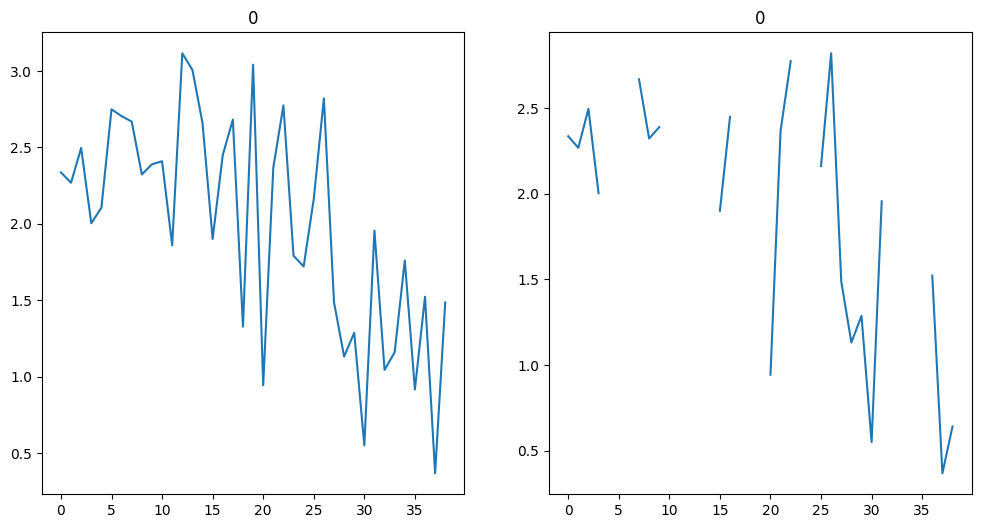

In [21]:
with open('datasets_new_scenarios/noise0.6_beta0.pickle','rb') as handle:
    trends_data = pickle.load(handle)
    
data_miss = introduce_mar(copy.deepcopy(trends_data))

# miss = 0.1
i = 70
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(trends_data[i]['seq'])
axes[0].set_title(trends_data[i]['label'])

axes[1].plot(data_miss[i]['seq'])
axes[1].set_title(data_miss[i]['label'])


In [22]:
for key, pat_dat in data_miss.items():
    time_stamp = np.where(~np.isnan(pat_dat['seq']))[0]
    pat_dat['timestamps'] = time_stamp

In [23]:
with open('datasets_new_scenarios/mar0.3_beta0.pickle','wb') as handle:
    pickle.dump(data_miss, handle)

In [24]:
with open('datasets_new_scenarios/noise0.6_beta0.pickle','rb') as handle:
    trends_data = pickle.load(handle)
    
data_miss = introduce_mar(copy.deepcopy(trends_data), target_missing_rate=0.6)

for key, pat_dat in data_miss.items():
    time_stamp = np.where(~np.isnan(pat_dat['seq']))[0]
    pat_dat['timestamps'] = time_stamp
    
with open('datasets_new_scenarios/mar0.6_beta0.pickle','wb') as handle:
    pickle.dump(data_miss, handle)

Iteration 1: Actual Missing Rate = 0.6815
Iteration 2: Actual Missing Rate = 0.6476
Iteration 3: Actual Missing Rate = 0.6162
Iteration 4: Actual Missing Rate = 0.5852
Iteration 5: Actual Missing Rate = 0.6140
Iteration 6: Actual Missing Rate = 0.5843
Iteration 7: Actual Missing Rate = 0.6129
Iteration 8: Actual Missing Rate = 0.5810
Iteration 9: Actual Missing Rate = 0.6106
Iteration 10: Actual Missing Rate = 0.5801
Iteration 11: Actual Missing Rate = 0.6094
Final Missing Rate Above 50: 0.8042
Final Missing Rate Below 50: 0.2681
Actual Missing Rate: 0.6094


### Missing not at random (MNAR)

In [25]:
def introduce_mnar_age(data, target_missing_rate=0.3, max_iter=100):
    np.random.seed(111)  # Set seed for reproducibility
    tolerance = 0.01  # Tolerance for reaching the target missing rate

    # Extract sequences and ages into arrays
    original_sequences = [np.array(values['seq']) for values in data.values()]
    ages = np.array([float(values['age']) for values in data.values()])

    # Initial missing rates for the two age groups
    missing_rate_below_50 = target_missing_rate * 0.5  # Start with half of the target for below 50
    missing_rate_above_50 = target_missing_rate * 1.5  # Start with 1.5x the target for above 50

    for iteration in range(max_iter):
        # Reset sequences to original before each iteration to avoid cumulative missingness
        sequences = [seq.copy() for seq in original_sequences]
        
        # Introduce missing values based on age groups (MNAR mechanism)
        for i, seq in enumerate(sequences):
            if ages[i] > 50:
                # Apply higher missing rate for patients above 50
                mask = np.random.rand(len(seq)) > missing_rate_above_50
            else:
                # Apply lower missing rate for patients 50 or below
                mask = np.random.rand(len(seq)) > missing_rate_below_50
            
            seq[~mask] = np.nan  # Set values to NaN based on the mask
        
        # Update the sequences back into the data structure for missingness calculation
        for i, (patid, values) in enumerate(data.items()):
            values['seq'] = sequences[i].tolist()

        # Calculate the overall missing rate using the provided function
        actual_missing_rate = calculate_missingness(data)
        
        # Print the actual missing rate after each iteration
        print(f"Iteration {iteration + 1}: Actual Missing Rate = {actual_missing_rate:.4f}")
        
        # Break if the actual missing rate is within the acceptable tolerance of the target
        if abs(actual_missing_rate - target_missing_rate) < tolerance:
            break
        
        # Adjust missing rates for both age groups based on the overall missing rate
        if actual_missing_rate > target_missing_rate:
            # Decrease both rates if the overall missing rate is too high
            missing_rate_above_50 *= 0.95
            missing_rate_below_50 *= 0.95
        else:
            # Increase both rates if the overall missing rate is too low
            missing_rate_above_50 *= 1.05
            missing_rate_below_50 *= 1.05

        # Ensure the missing rates are within reasonable bounds [0, 1]
        missing_rate_above_50 = min(max(missing_rate_above_50, 0), 1)
        missing_rate_below_50 = min(max(missing_rate_below_50, 0), 1)
    
    # Output the final missing rates and actual missing rate achieved
    print(f'Final Missing Rate Above 50: {missing_rate_above_50:.4f}')
    print(f'Final Missing Rate Below 50: {missing_rate_below_50:.4f}')
    print(f'Actual Missing Rate: {actual_missing_rate:.4f}')
    
    return data

Iteration 1: Actual Missing Rate = 0.3548
Iteration 2: Actual Missing Rate = 0.3371
Iteration 3: Actual Missing Rate = 0.3206
Iteration 4: Actual Missing Rate = 0.3046
Final Missing Rate Above 50: 0.3858
Final Missing Rate Below 50: 0.1286
Actual Missing Rate: 0.3046


Text(0.5, 1.0, '0')

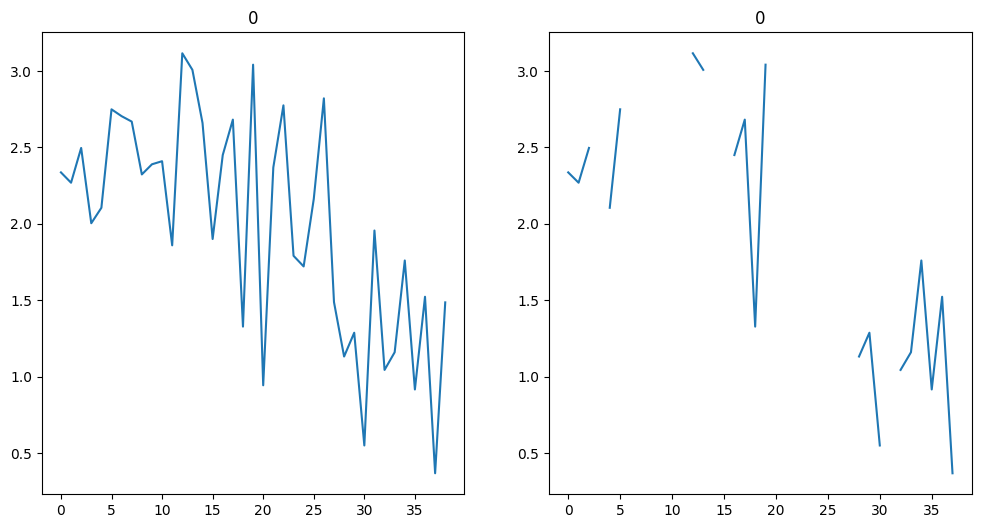

In [26]:
import pickle
with open('datasets_new_scenarios/noise0.6_beta0.pickle','rb') as handle:
    trends_data = pickle.load(handle)
    
data_miss = introduce_mnar_age(copy.deepcopy(trends_data))

# miss = 0.1
i = 70
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(trends_data[i]['seq'])
axes[0].set_title(trends_data[i]['label'])

axes[1].plot(data_miss[i]['seq'])
axes[1].set_title(data_miss[i]['label'])

In [27]:
for key, pat_dat in data_miss.items():
    time_stamp = np.where(~np.isnan(pat_dat['seq']))[0]
    pat_dat['timestamps'] = time_stamp

In [28]:
with open('datasets_new_scenarios/mnar0.3_beta0.pickle','wb') as handle:
    pickle.dump(data_miss, handle)

In [29]:
with open('datasets_new_scenarios/noise0.6_beta0.pickle','rb') as handle:
    trends_data = pickle.load(handle)
    
data_miss = introduce_mnar_age(copy.deepcopy(trends_data), target_missing_rate=0.6)
for key, pat_dat in data_miss.items():
    time_stamp = np.where(~np.isnan(pat_dat['seq']))[0]
    pat_dat['timestamps'] = time_stamp

with open('datasets_new_scenarios/mnar0.6_beta0.pickle','wb') as handle:
    pickle.dump(data_miss, handle)

Iteration 1: Actual Missing Rate = 0.7078
Iteration 2: Actual Missing Rate = 0.6724
Iteration 3: Actual Missing Rate = 0.6399
Iteration 4: Actual Missing Rate = 0.6074
Final Missing Rate Above 50: 0.7716
Final Missing Rate Below 50: 0.2572
Actual Missing Rate: 0.6074


normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6523896651268005
Epoch [1/2000], Val Loss: 0.6124919185638428
Epoch [2/2000], Train Loss: 0.5891026105086009
Epoch [2/2000], Val Loss: 0.5679063217639924
Epoch [3/2000], Train Loss: 0.5484592049916586
Epoch [3/2000], Val Loss: 0.5511925466060639
Epoch [4/2000], Train Loss: 0.5150088452100754
Epoch [4/2000], Val Loss: 0.5064786703586578
Epoch [5/2000], Train Loss: 0.47671323680877686
Epoch [5/2000], Val Loss: 0.47603760433197023
Epoch [6/2000], Train Loss: 0.4423223199446996
Epoch [6/2000], Val Loss: 0.4455510140657425
Epoch [7/2000], Train Loss: 0.39658161155382793
Epoch [7/2000], Val Loss: 0.40633176839351653
Epoch [8/2000], Train Loss: 0.3531078516244888
Epoch [8/2000], Val Loss: 0.37080820119380953
Epoch [9/2000], Train Loss: 0.30885821364323296
Epoch [9/2000], Val Loss: 0.3514017695188522
Epoch [10/2000], Train Loss: 0.27026922633250555
Epoch [10/2000], Val Loss: 0.31113999223709105
Epoch [11/2000], Tr

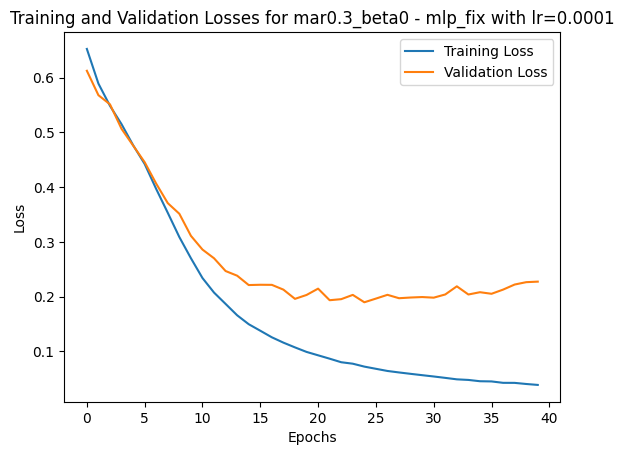

C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_mlp_fix_mar0.3_beta0_lr0.0001_lr0.0001.pt


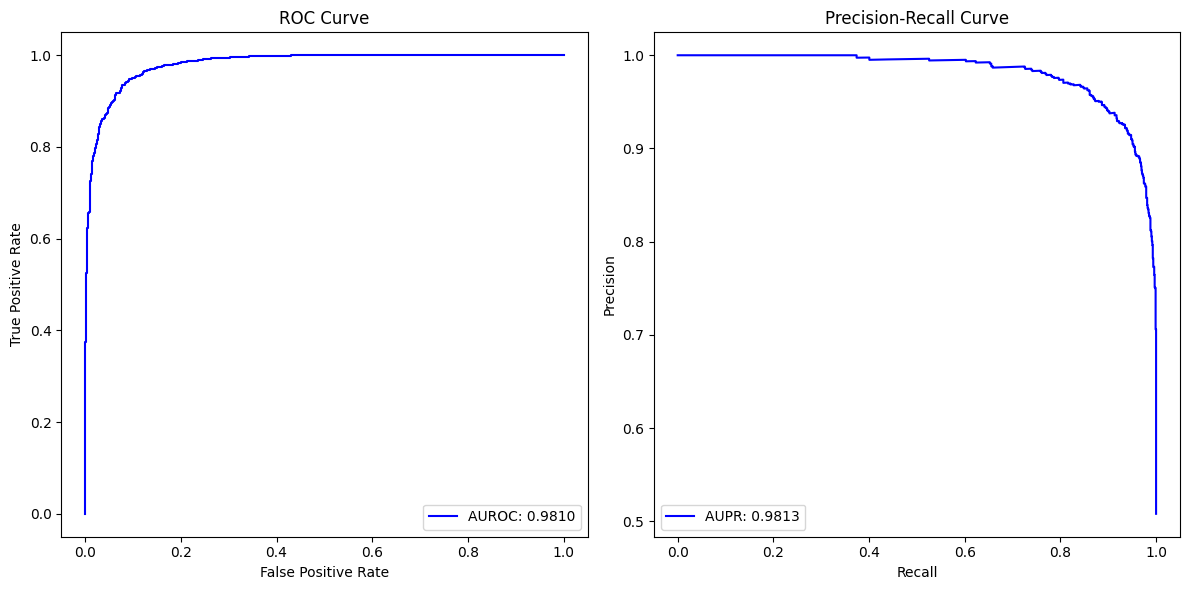

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6782076959609985
Epoch [1/2000], Val Loss: 0.6638666210174561
Epoch [2/2000], Train Loss: 0.6570504387219747
Epoch [2/2000], Val Loss: 0.6524518122673034
Epoch [3/2000], Train Loss: 0.63746883670489
Epoch [3/2000], Val Loss: 0.6394948115348816
Epoch [4/2000], Train Loss: 0.6194717255433401
Epoch [4/2000], Val Loss: 0.627596333026886
Epoch [5/2000], Train Loss: 0.6005974152088165
Epoch [5/2000], Val Loss: 0.6156570122241974
Epoch [6/2000], Train Loss: 0.579437507390976
Epoch [6/2000], Val Loss: 0.5995121207237244
Epoch [7/2000], Train Loss: 0.5537790970802308
Epoch [7/2000], Val Loss: 0.5816368064880371
Epoch [8/2000], Train Loss: 0.5228885289033254
Epoch [8/2000], Val Loss: 0.5599309821128845
Epoch [9/2000], Train Loss: 0.4923599090576172
Epoch [9/2000], Val Loss: 0.5378192250728607
Epoch [10/2000], Train Loss: 0.45619944310188293
Epoch [10/2000], Val Loss: 0.5157621247768402
Epoch [11/2000], Train Loss: 0

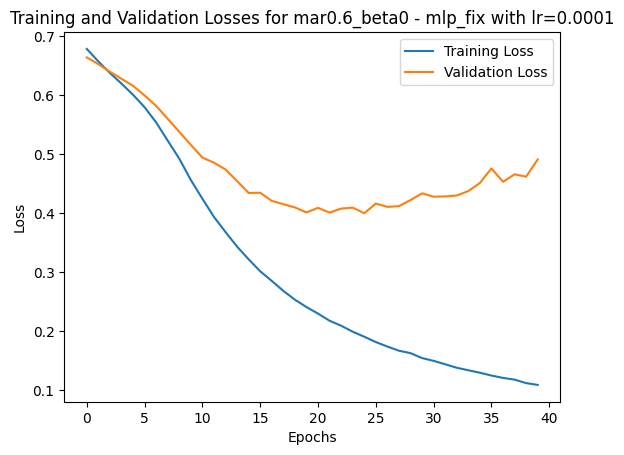

C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_mlp_fix_mar0.6_beta0_lr0.0001_lr0.0001.pt


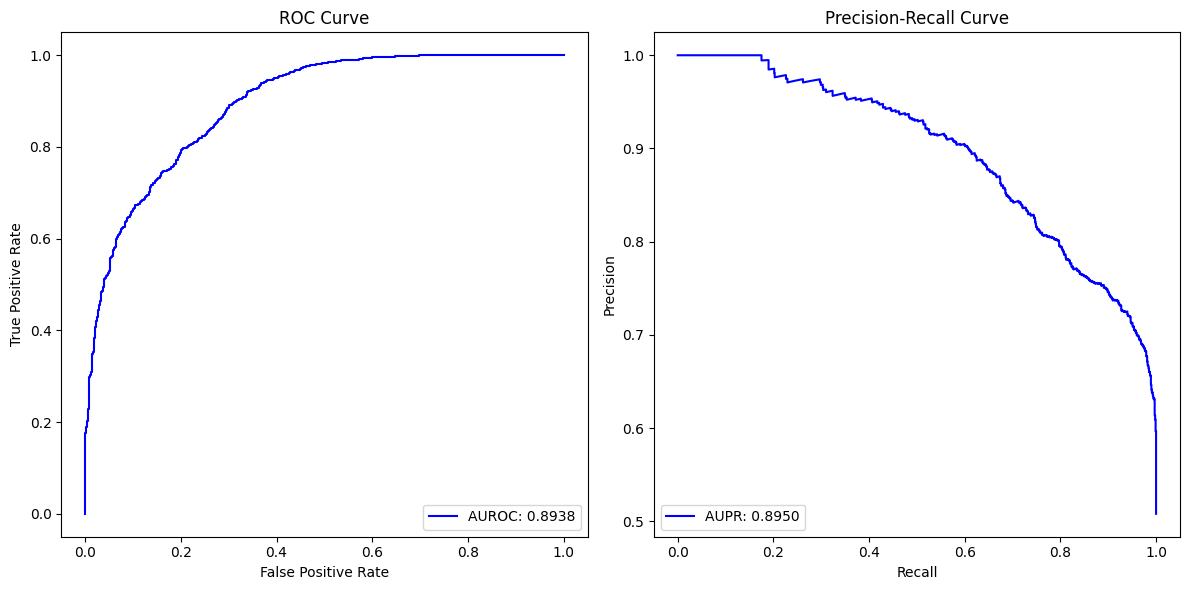

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.638134127775828
Epoch [1/2000], Val Loss: 0.5827257416248321
Epoch [2/2000], Train Loss: 0.5571390790144602
Epoch [2/2000], Val Loss: 0.5486715874671936
Epoch [3/2000], Train Loss: 0.5276136669317881
Epoch [3/2000], Val Loss: 0.5300191752910614
Epoch [4/2000], Train Loss: 0.5032292144695918
Epoch [4/2000], Val Loss: 0.5153194727897644
Epoch [5/2000], Train Loss: 0.4767738833427429
Epoch [5/2000], Val Loss: 0.49603871273994443
Epoch [6/2000], Train Loss: 0.4427765699227651
Epoch [6/2000], Val Loss: 0.450772314786911
Epoch [7/2000], Train Loss: 0.40010841671625774
Epoch [7/2000], Val Loss: 0.41107096695899964
Epoch [8/2000], Train Loss: 0.3512707467873891
Epoch [8/2000], Val Loss: 0.39322364592552184
Epoch [9/2000], Train Loss: 0.30488161595662433
Epoch [9/2000], Val Loss: 0.33514428102970123
Epoch [10/2000], Train Loss: 0.26173470056056974
Epoch [10/2000], Val Loss: 0.3025024958252907
Epoch [11/2000], Train

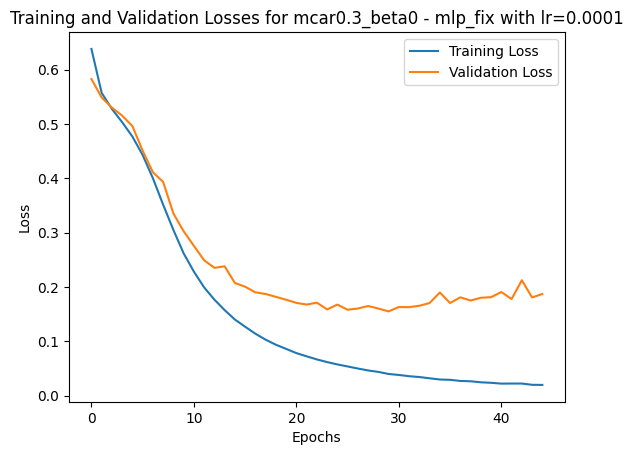

C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_mlp_fix_mcar0.3_beta0_lr0.0001_lr0.0001.pt


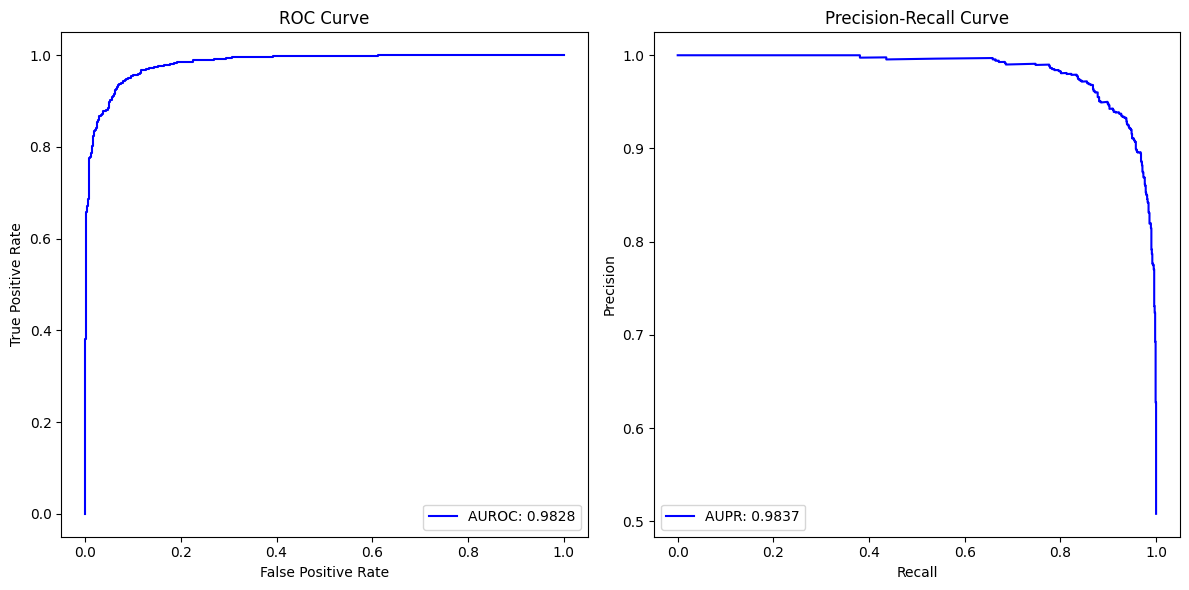

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6721782660484314
Epoch [1/2000], Val Loss: 0.6506455740928649
Epoch [2/2000], Train Loss: 0.6422723256746928
Epoch [2/2000], Val Loss: 0.639793232679367
Epoch [3/2000], Train Loss: 0.6278763240973154
Epoch [3/2000], Val Loss: 0.6310101413726806
Epoch [4/2000], Train Loss: 0.6138556061585744
Epoch [4/2000], Val Loss: 0.6223719370365143
Epoch [5/2000], Train Loss: 0.5952782130241394
Epoch [5/2000], Val Loss: 0.6105368258953094
Epoch [6/2000], Train Loss: 0.5711105035940806
Epoch [6/2000], Val Loss: 0.5946414070129394
Epoch [7/2000], Train Loss: 0.5402120371659597
Epoch [7/2000], Val Loss: 0.5817692933082581
Epoch [8/2000], Train Loss: 0.503826737165451
Epoch [8/2000], Val Loss: 0.5497988476753235
Epoch [9/2000], Train Loss: 0.4608630542755127
Epoch [9/2000], Val Loss: 0.5237727482318878
Epoch [10/2000], Train Loss: 0.4172494277159373
Epoch [10/2000], Val Loss: 0.49388806986808775
Epoch [11/2000], Train Loss:

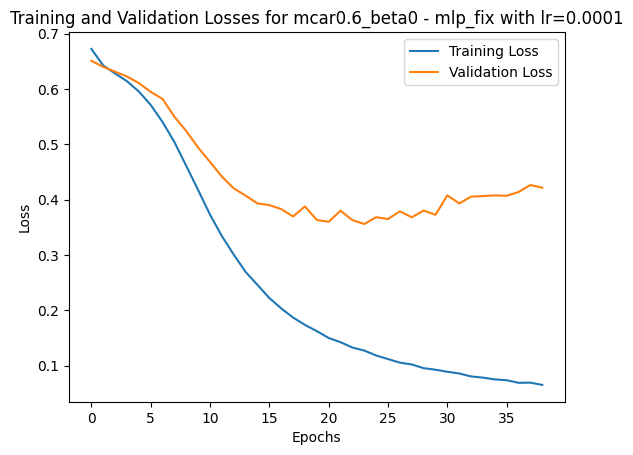

C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_mlp_fix_mcar0.6_beta0_lr0.0001_lr0.0001.pt


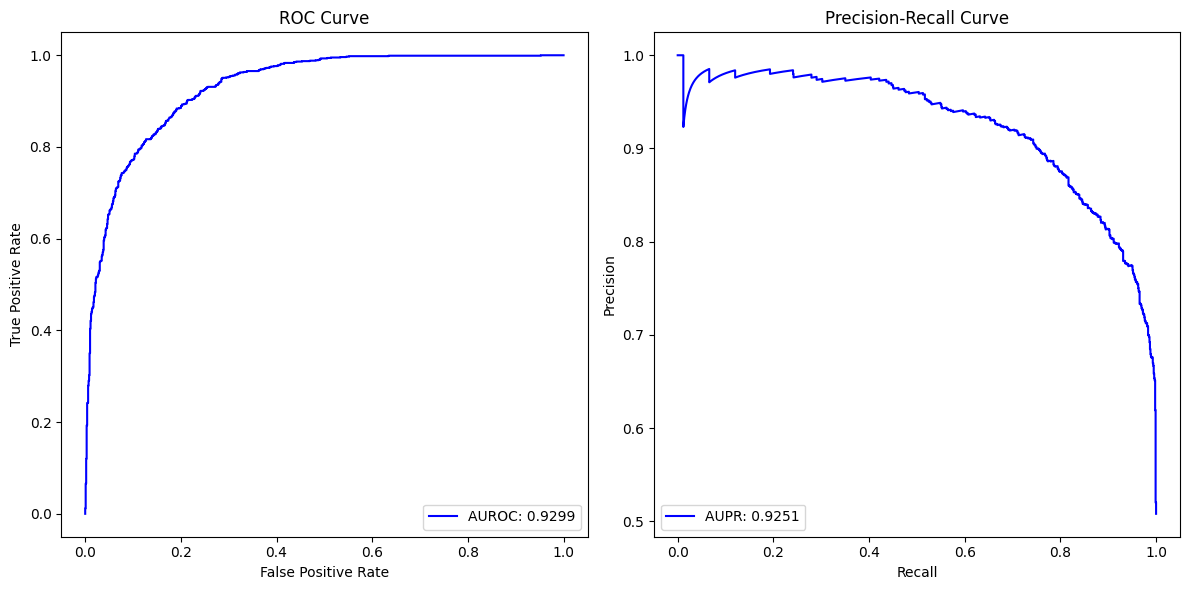

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6406919690767924
Epoch [1/2000], Val Loss: 0.5986204497814178
Epoch [2/2000], Train Loss: 0.5769665493965149
Epoch [2/2000], Val Loss: 0.5777494802474975
Epoch [3/2000], Train Loss: 0.5444402492841085
Epoch [3/2000], Val Loss: 0.5406997690200805
Epoch [4/2000], Train Loss: 0.5135699156920115
Epoch [4/2000], Val Loss: 0.5156011837720871
Epoch [5/2000], Train Loss: 0.4822810502052307
Epoch [5/2000], Val Loss: 0.4881083090305328
Epoch [6/2000], Train Loss: 0.4468587758541107
Epoch [6/2000], Val Loss: 0.4579243257045746
Epoch [7/2000], Train Loss: 0.40824541489283245
Epoch [7/2000], Val Loss: 0.42575551092624664
Epoch [8/2000], Train Loss: 0.36366607232888537
Epoch [8/2000], Val Loss: 0.38462097954750063
Epoch [9/2000], Train Loss: 0.3158865213791529
Epoch [9/2000], Val Loss: 0.3458433430194855
Epoch [10/2000], Train Loss: 0.27392691296339033
Epoch [10/2000], Val Loss: 0.31390498888492585
Epoch [11/2000], Trai

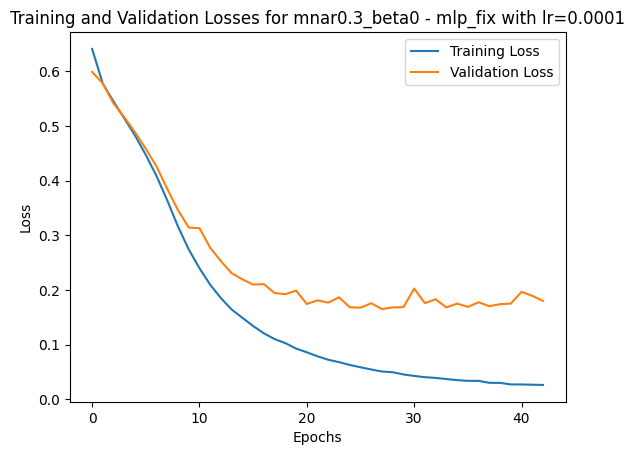

C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_mlp_fix_mnar0.3_beta0_lr0.0001_lr0.0001.pt


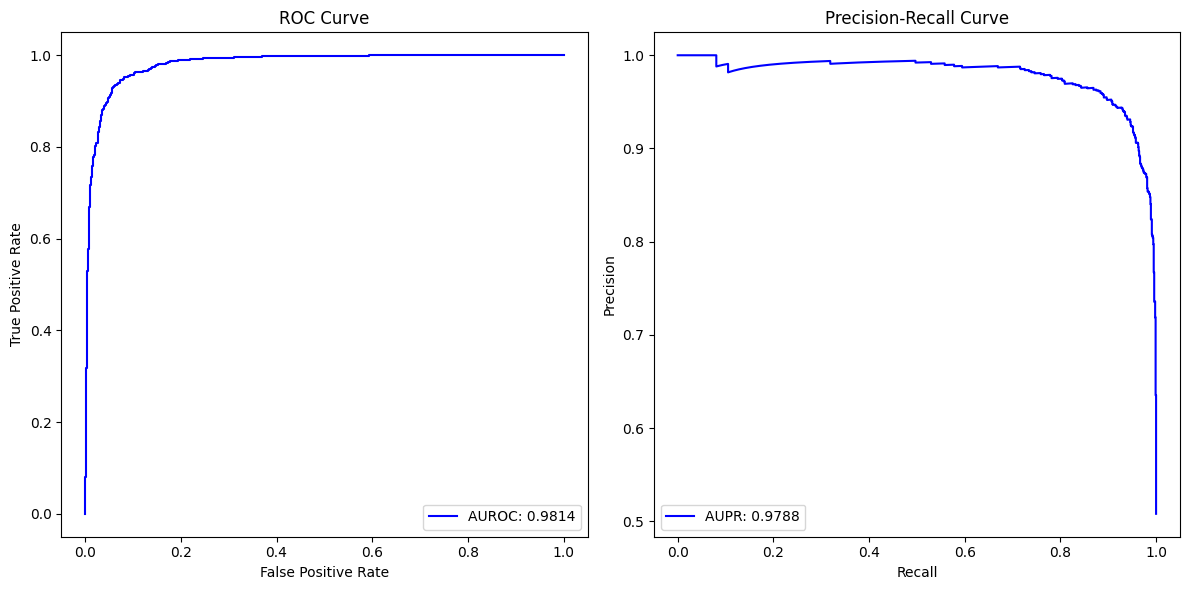

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6760987447102864
Epoch [1/2000], Val Loss: 0.6582494125366211
Epoch [2/2000], Train Loss: 0.6511543893019358
Epoch [2/2000], Val Loss: 0.6453548386096954
Epoch [3/2000], Train Loss: 0.6313686016400655
Epoch [3/2000], Val Loss: 0.6291645600795746
Epoch [4/2000], Train Loss: 0.6102943851153055
Epoch [4/2000], Val Loss: 0.6132826271057129
Epoch [5/2000], Train Loss: 0.5867445282936096
Epoch [5/2000], Val Loss: 0.5957433180809021
Epoch [6/2000], Train Loss: 0.5588302946090699
Epoch [6/2000], Val Loss: 0.5797032687664032
Epoch [7/2000], Train Loss: 0.5273180843194326
Epoch [7/2000], Val Loss: 0.5537682130336762
Epoch [8/2000], Train Loss: 0.4930759785970052
Epoch [8/2000], Val Loss: 0.5275989708900451
Epoch [9/2000], Train Loss: 0.4574796932140986
Epoch [9/2000], Val Loss: 0.5009553465843201
Epoch [10/2000], Train Loss: 0.4239505955775579
Epoch [10/2000], Val Loss: 0.493413813829422
Epoch [11/2000], Train Loss:

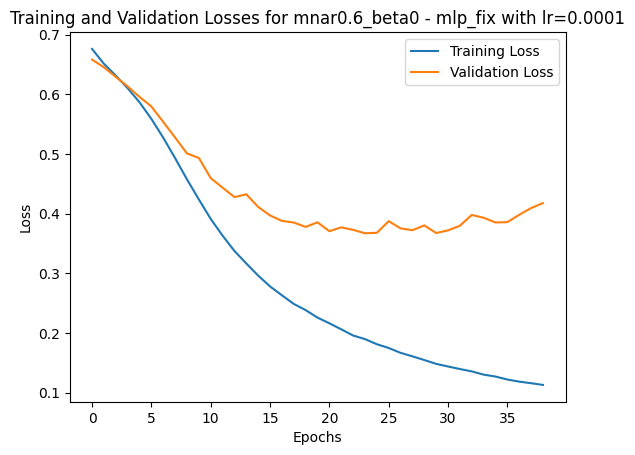

Model loaded from outputs/baseline_mlp_fix_mnar0.6_beta0_lr0.0001_lr0.0001.pt


C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

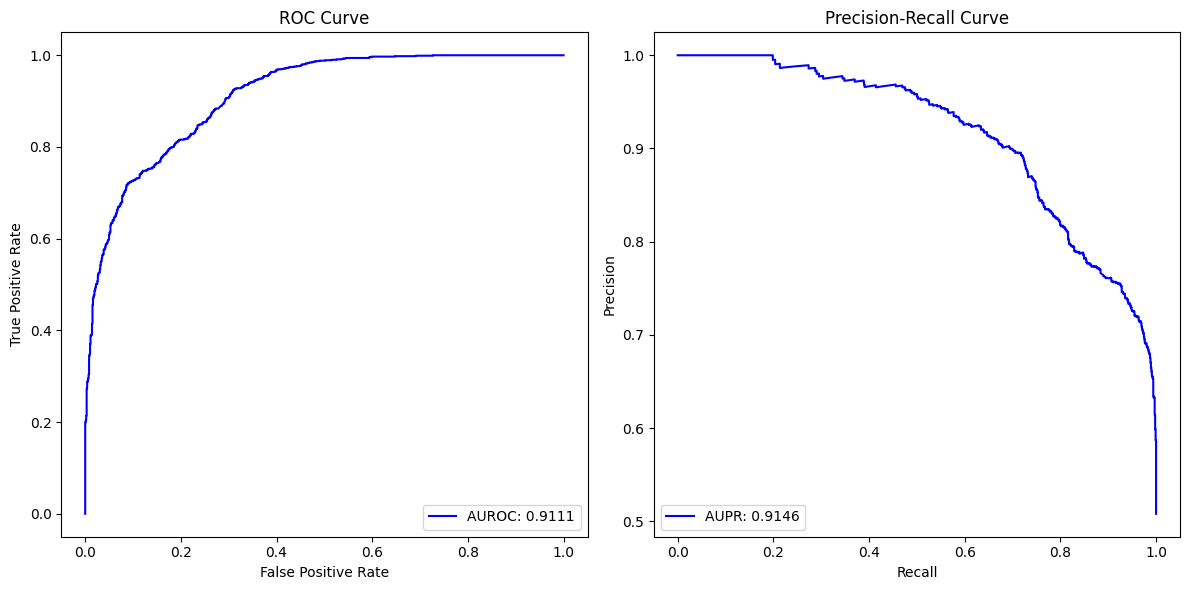

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.48108016669750214
Epoch [1/2000], Val Loss: 0.2585211789608002
Epoch [2/2000], Train Loss: 0.16090649449825287
Epoch [2/2000], Val Loss: 0.10379413212835789
Epoch [3/2000], Train Loss: 0.07891949997345607
Epoch [3/2000], Val Loss: 0.0656416116245091
Epoch [4/2000], Train Loss: 0.052573314265658457
Epoch [4/2000], Val Loss: 0.050833664912730454
Epoch [5/2000], Train Loss: 0.041323044114435714
Epoch [5/2000], Val Loss: 0.04023710952606052
Epoch [6/2000], Train Loss: 0.0349598439320301
Epoch [6/2000], Val Loss: 0.04323878816142678
Epoch [7/2000], Train Loss: 0.030362835503648967
Epoch [7/2000], Val Loss: 0.03283580017089844
Epoch [8/2000], Train Loss: 0.02866149375740982
Epoch [8/2000], Val Loss: 0.03022299312101677
Epoch [9/2000], Train Loss: 0.025222099000937307
Epoch [9/2000], Val Loss: 0.0289776831548661
Epoch [10/2000], Train Loss: 0.023579340144526215
Epoch [10/2000], Val Loss: 0.04013602830190212
Epoch

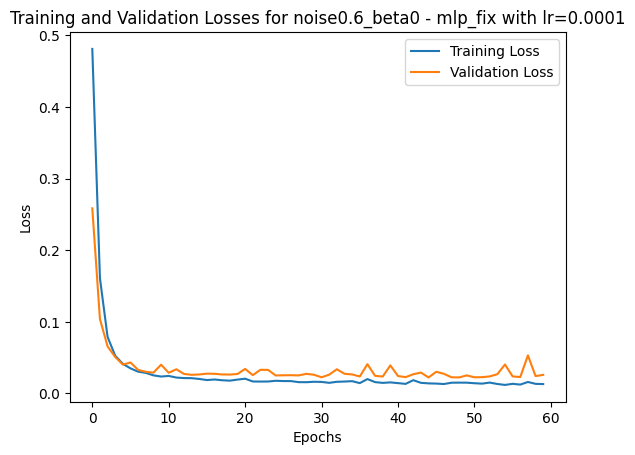

C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_mlp_fix_noise0.6_beta0_lr0.0001_lr0.0001.pt


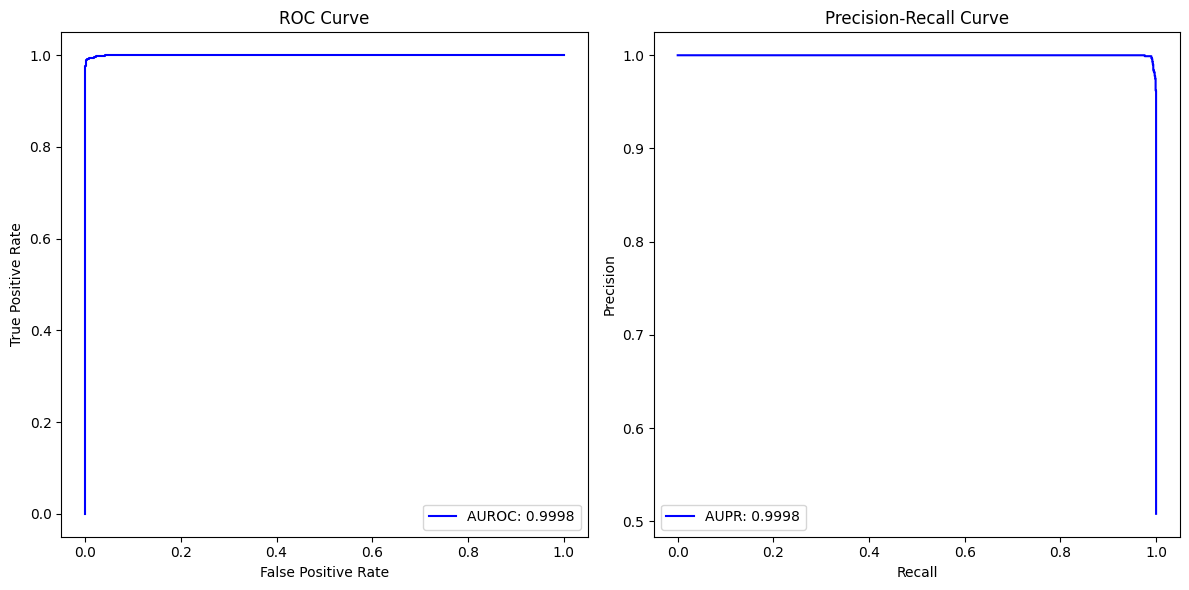

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6966919515927633
Epoch [1/2000], Val Loss: 0.6973644275665283
Epoch [2/2000], Train Loss: 0.6929508662223816
Epoch [2/2000], Val Loss: 0.6935709772109986
Epoch [3/2000], Train Loss: 0.6896928165753683
Epoch [3/2000], Val Loss: 0.6902623567581176
Epoch [4/2000], Train Loss: 0.6868460496266683
Epoch [4/2000], Val Loss: 0.6873703680038452
Epoch [5/2000], Train Loss: 0.6842770819664001
Epoch [5/2000], Val Loss: 0.6848118281364441
Epoch [6/2000], Train Loss: 0.6819990824063619
Epoch [6/2000], Val Loss: 0.6825375428199768
Epoch [7/2000], Train Loss: 0.6800093927383423
Epoch [7/2000], Val Loss: 0.6805169587135315
Epoch [8/2000], Train Loss: 0.6782299949328104
Epoch [8/2000], Val Loss: 0.6787388105392456
Epoch [9/2000], Train Loss: 0.6766232735315959
Epoch [9/2000], Val Loss: 0.6771292395591736
Epoch [10/2000], Train Loss: 0.675140961488088
Epoch [10/2000], Val Loss: 0.675649070262909
Epoch [11/2000], Train Loss: 

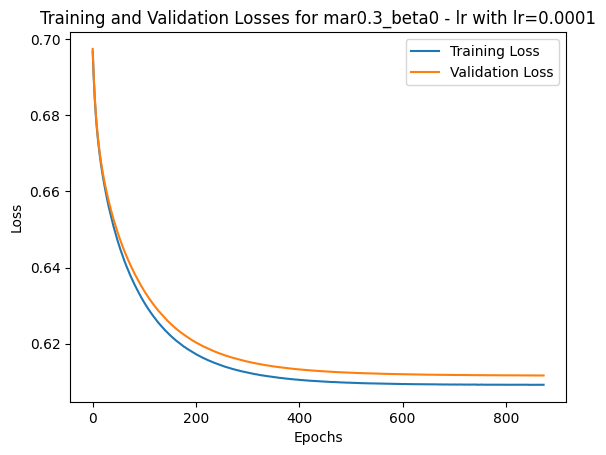

C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_lr_mar0.3_beta0_lr0.0001_lr0.0001.pt


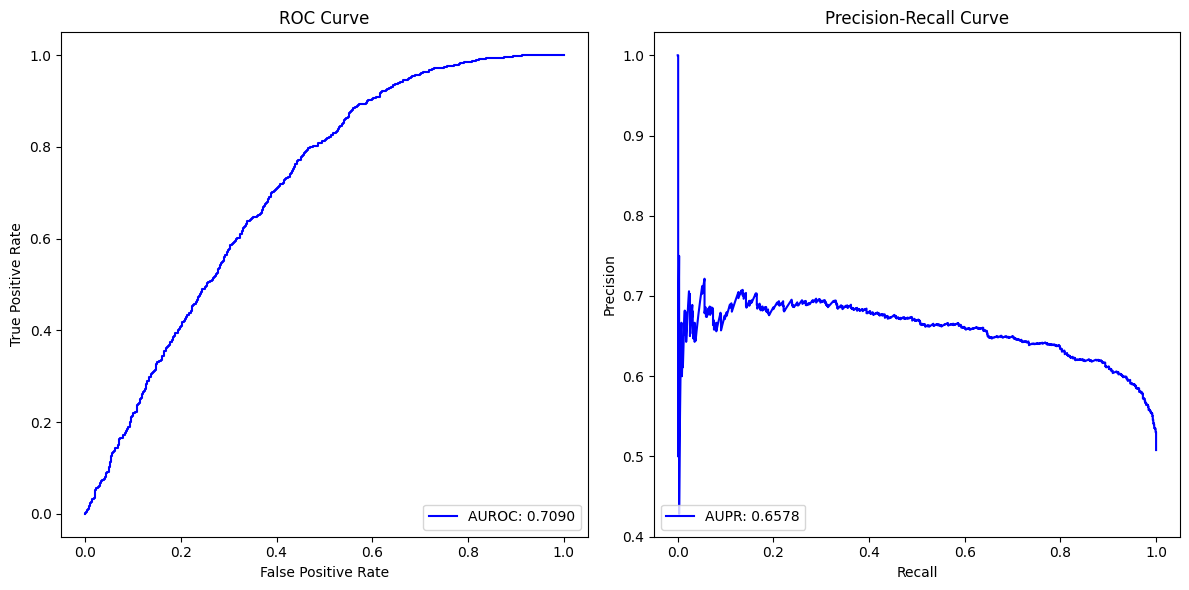

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6958693178494771
Epoch [1/2000], Val Loss: 0.6924628276824951
Epoch [2/2000], Train Loss: 0.6941653378804524
Epoch [2/2000], Val Loss: 0.6907910423278809
Epoch [3/2000], Train Loss: 0.6926207044919331
Epoch [3/2000], Val Loss: 0.6892386693954468
Epoch [4/2000], Train Loss: 0.6912159514427185
Epoch [4/2000], Val Loss: 0.6877760109901428
Epoch [5/2000], Train Loss: 0.6899133712450664
Epoch [5/2000], Val Loss: 0.6864807629585266
Epoch [6/2000], Train Loss: 0.6887411991755168
Epoch [6/2000], Val Loss: 0.6853043446540833
Epoch [7/2000], Train Loss: 0.687663255850474
Epoch [7/2000], Val Loss: 0.6842219614982605
Epoch [8/2000], Train Loss: 0.6866543030738831
Epoch [8/2000], Val Loss: 0.6832459154129028
Epoch [9/2000], Train Loss: 0.6857210882504781
Epoch [9/2000], Val Loss: 0.682336033821106
Epoch [10/2000], Train Loss: 0.6848598375320435
Epoch [10/2000], Val Loss: 0.6814862027168274
Epoch [11/2000], Train Loss: 

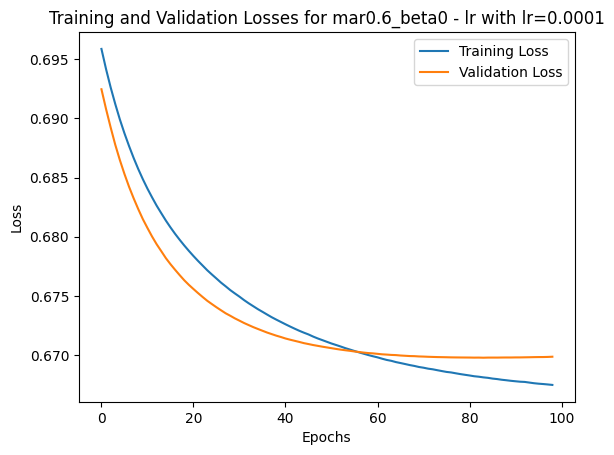

Model loaded from outputs/baseline_lr_mar0.6_beta0_lr0.0001_lr0.0001.pt


C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

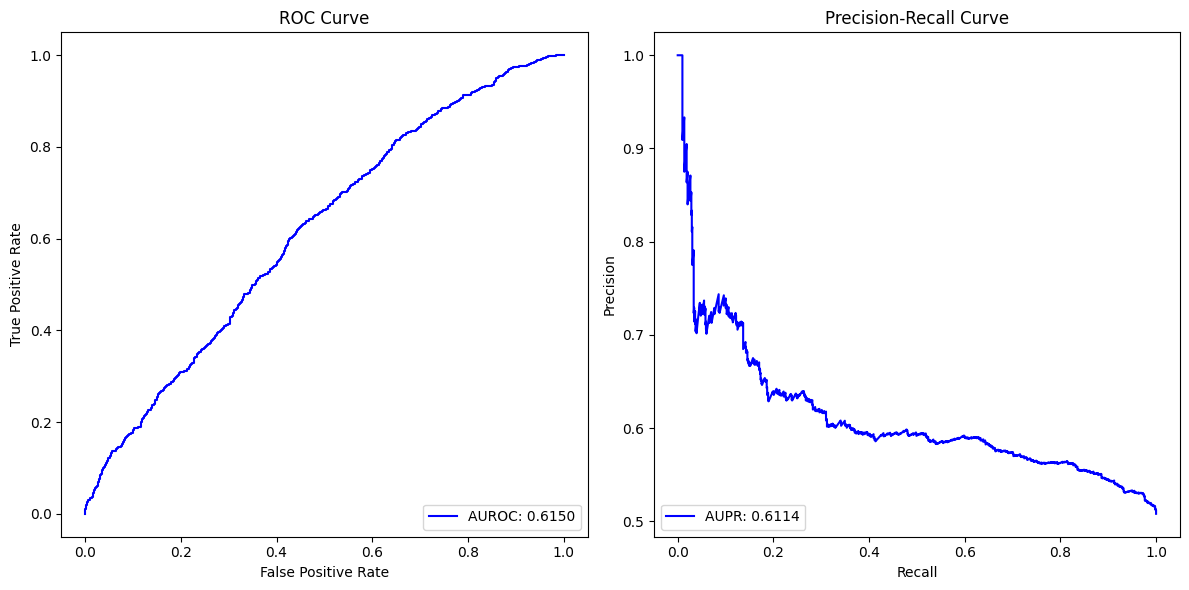

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.686208441734314
Epoch [1/2000], Val Loss: 0.6803584294319153
Epoch [2/2000], Train Loss: 0.683848653157552
Epoch [2/2000], Val Loss: 0.6781993455886841
Epoch [3/2000], Train Loss: 0.681848609606425
Epoch [3/2000], Val Loss: 0.6762506313323975
Epoch [4/2000], Train Loss: 0.6800144039789836
Epoch [4/2000], Val Loss: 0.6745504097938537
Epoch [5/2000], Train Loss: 0.6783564252853393
Epoch [5/2000], Val Loss: 0.6729729409217835
Epoch [6/2000], Train Loss: 0.6768346309661866
Epoch [6/2000], Val Loss: 0.6714604091644287
Epoch [7/2000], Train Loss: 0.6753512692451477
Epoch [7/2000], Val Loss: 0.6700433173179626
Epoch [8/2000], Train Loss: 0.6740156397819519
Epoch [8/2000], Val Loss: 0.6687622938156128
Epoch [9/2000], Train Loss: 0.6726693922678629
Epoch [9/2000], Val Loss: 0.6675557866096496
Epoch [10/2000], Train Loss: 0.671428717772166
Epoch [10/2000], Val Loss: 0.6664253277778626
Epoch [11/2000], Train Loss: 0.

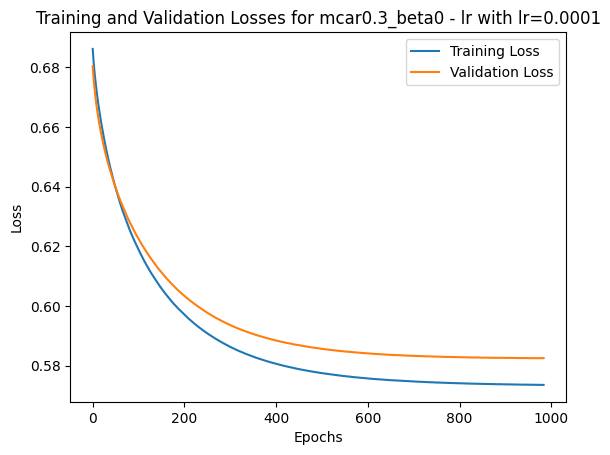

C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_lr_mcar0.3_beta0_lr0.0001_lr0.0001.pt


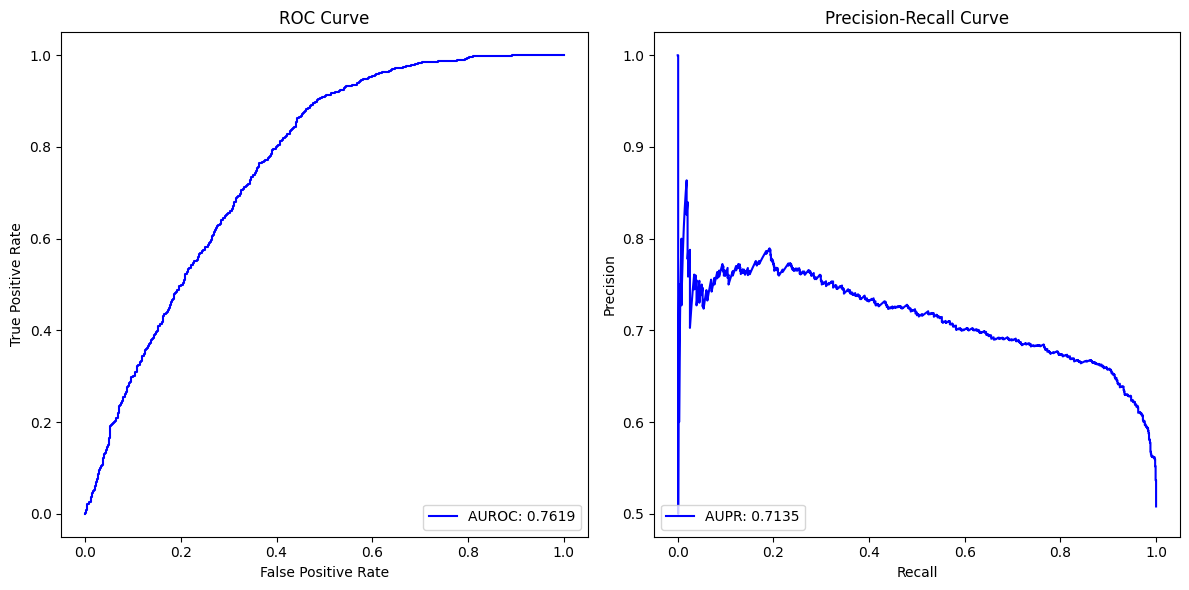

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6987842469215393
Epoch [1/2000], Val Loss: 0.699672019958496
Epoch [2/2000], Train Loss: 0.6964170455932617
Epoch [2/2000], Val Loss: 0.6972077369689942
Epoch [3/2000], Train Loss: 0.6942155636151631
Epoch [3/2000], Val Loss: 0.6949474964141845
Epoch [4/2000], Train Loss: 0.6921754078865051
Epoch [4/2000], Val Loss: 0.6928191680908203
Epoch [5/2000], Train Loss: 0.6902932039896648
Epoch [5/2000], Val Loss: 0.6909061298370361
Epoch [6/2000], Train Loss: 0.6885299857457479
Epoch [6/2000], Val Loss: 0.6891099700927734
Epoch [7/2000], Train Loss: 0.6869052823384603
Epoch [7/2000], Val Loss: 0.6874313344955444
Epoch [8/2000], Train Loss: 0.6853837563196818
Epoch [8/2000], Val Loss: 0.6858631849288941
Epoch [9/2000], Train Loss: 0.6839757345517476
Epoch [9/2000], Val Loss: 0.684403413772583
Epoch [10/2000], Train Loss: 0.6826595489184062
Epoch [10/2000], Val Loss: 0.6831007199287414
Epoch [11/2000], Train Loss: 

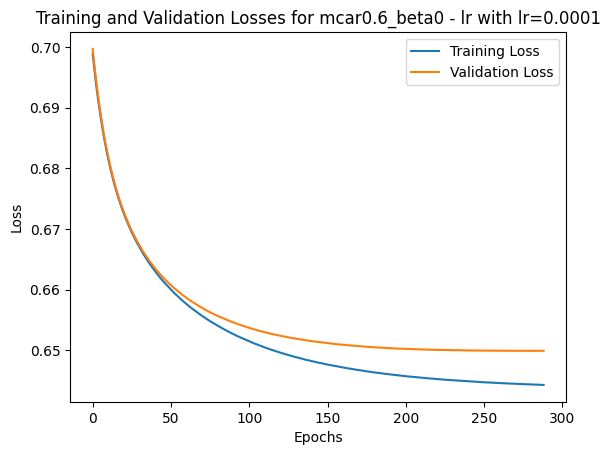

Model loaded from outputs/baseline_lr_mcar0.6_beta0_lr0.0001_lr0.0001.pt


C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

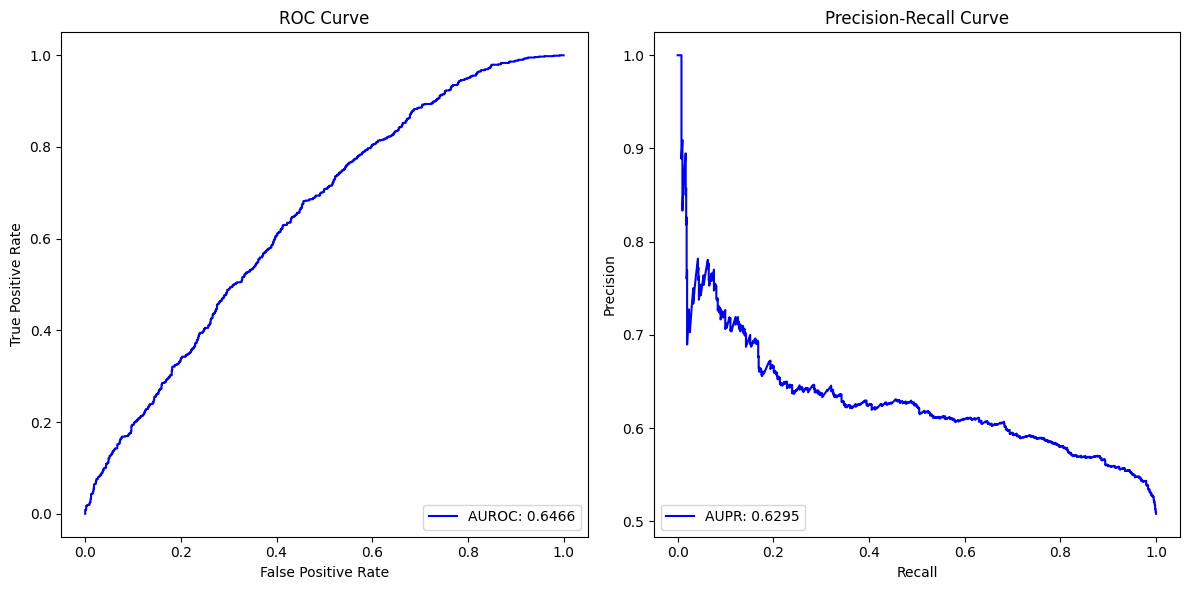

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6826184533437093
Epoch [1/2000], Val Loss: 0.6801045231819153
Epoch [2/2000], Train Loss: 0.6803401379585267
Epoch [2/2000], Val Loss: 0.6778410511016846
Epoch [3/2000], Train Loss: 0.6783201274871826
Epoch [3/2000], Val Loss: 0.6757449707984924
Epoch [4/2000], Train Loss: 0.6764999173482259
Epoch [4/2000], Val Loss: 0.6739987030029296
Epoch [5/2000], Train Loss: 0.6748839116096497
Epoch [5/2000], Val Loss: 0.6723585176467896
Epoch [6/2000], Train Loss: 0.6733687524795532
Epoch [6/2000], Val Loss: 0.6708718862533569
Epoch [7/2000], Train Loss: 0.6719980786641438
Epoch [7/2000], Val Loss: 0.669501980304718
Epoch [8/2000], Train Loss: 0.6707303802172343
Epoch [8/2000], Val Loss: 0.6682591834068299
Epoch [9/2000], Train Loss: 0.6694872301419575
Epoch [9/2000], Val Loss: 0.6670788764953614
Epoch [10/2000], Train Loss: 0.6683358028729757
Epoch [10/2000], Val Loss: 0.6659720115661621
Epoch [11/2000], Train Loss:

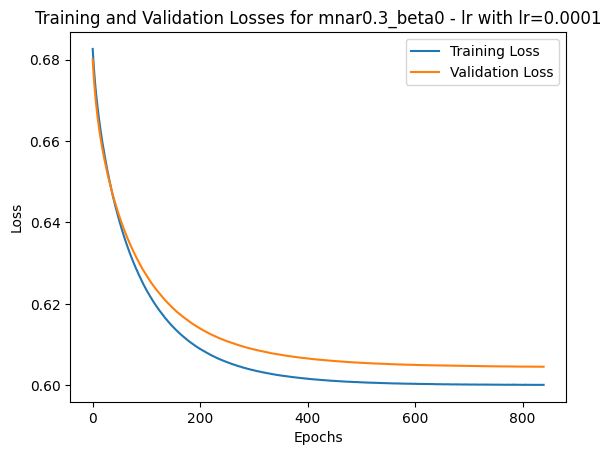

C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_lr_mnar0.3_beta0_lr0.0001_lr0.0001.pt


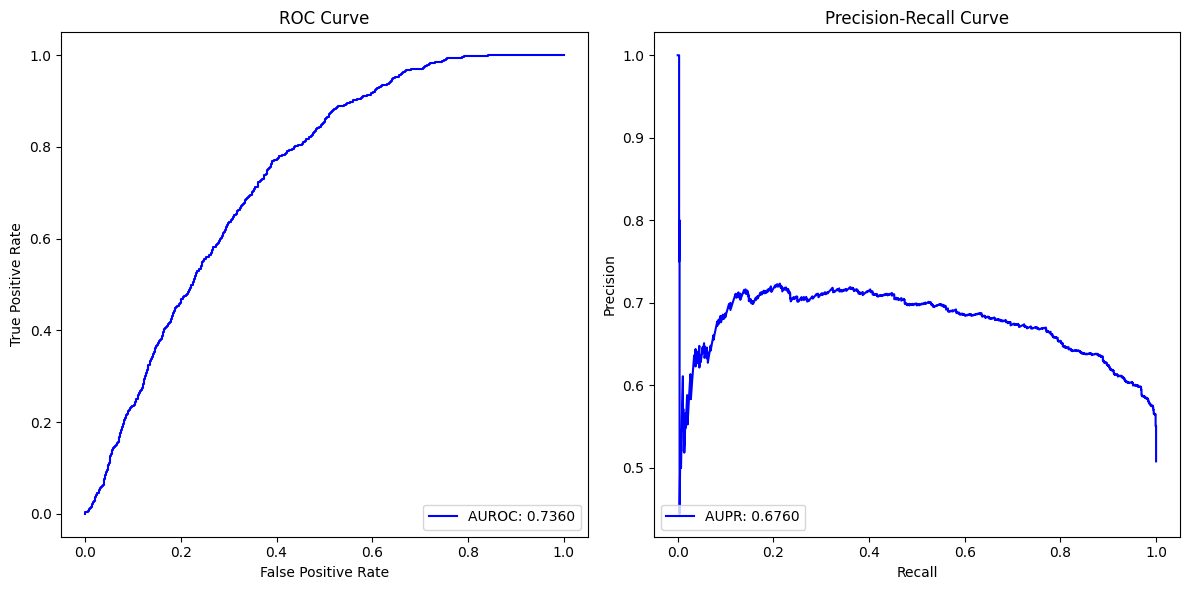

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6942451535860698
Epoch [1/2000], Val Loss: 0.6936163802146912
Epoch [2/2000], Train Loss: 0.6923255823453267
Epoch [2/2000], Val Loss: 0.6918659157752991
Epoch [3/2000], Train Loss: 0.6907440501848857
Epoch [3/2000], Val Loss: 0.6903853678703308
Epoch [4/2000], Train Loss: 0.6893743928273519
Epoch [4/2000], Val Loss: 0.6890471153259278
Epoch [5/2000], Train Loss: 0.688096297899882
Epoch [5/2000], Val Loss: 0.6878539075851441
Epoch [6/2000], Train Loss: 0.6869432962735494
Epoch [6/2000], Val Loss: 0.686700234413147
Epoch [7/2000], Train Loss: 0.6858562262852986
Epoch [7/2000], Val Loss: 0.6856815629005432
Epoch [8/2000], Train Loss: 0.6848521525065104
Epoch [8/2000], Val Loss: 0.6846896662712098
Epoch [9/2000], Train Loss: 0.6839206155141194
Epoch [9/2000], Val Loss: 0.6838048877716064
Epoch [10/2000], Train Loss: 0.682999859491984
Epoch [10/2000], Val Loss: 0.6829460744857788
Epoch [11/2000], Train Loss: 0

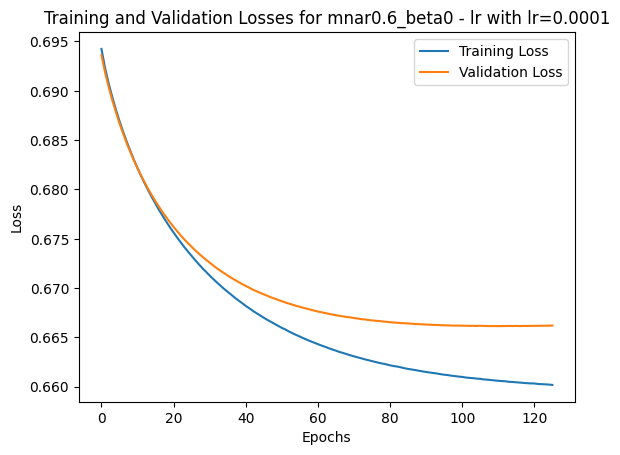

Model loaded from outputs/baseline_lr_mnar0.6_beta0_lr0.0001_lr0.0001.pt


C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

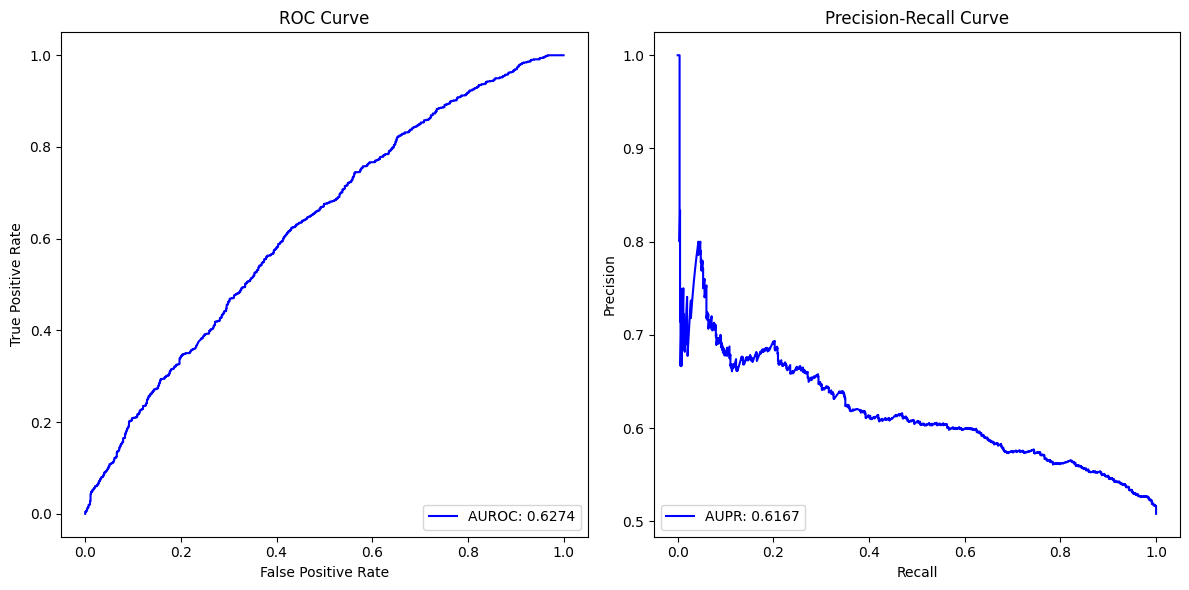

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6870591270128886
Epoch [1/2000], Val Loss: 0.6811985964775086
Epoch [2/2000], Train Loss: 0.6803354013760885
Epoch [2/2000], Val Loss: 0.6765353026390075
Epoch [3/2000], Train Loss: 0.6771542916297912
Epoch [3/2000], Val Loss: 0.6735513057708741
Epoch [4/2000], Train Loss: 0.6746254248619079
Epoch [4/2000], Val Loss: 0.6710616893768311
Epoch [5/2000], Train Loss: 0.6723763367335002
Epoch [5/2000], Val Loss: 0.6687937064170837
Epoch [6/2000], Train Loss: 0.6702551697095235
Epoch [6/2000], Val Loss: 0.6667541794776917
Epoch [7/2000], Train Loss: 0.6682648040453593
Epoch [7/2000], Val Loss: 0.6648230109214782
Epoch [8/2000], Train Loss: 0.6663680957158407
Epoch [8/2000], Val Loss: 0.6629702043533325
Epoch [9/2000], Train Loss: 0.6645677965482076
Epoch [9/2000], Val Loss: 0.6612284417152405
Epoch [10/2000], Train Loss: 0.6627590486208598
Epoch [10/2000], Val Loss: 0.6595495815277099
Epoch [11/2000], Train Loss

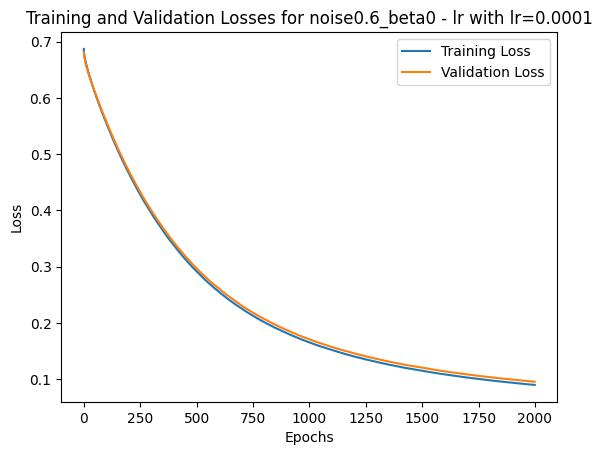

C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_lr_noise0.6_beta0_lr0.0001_lr0.0001.pt


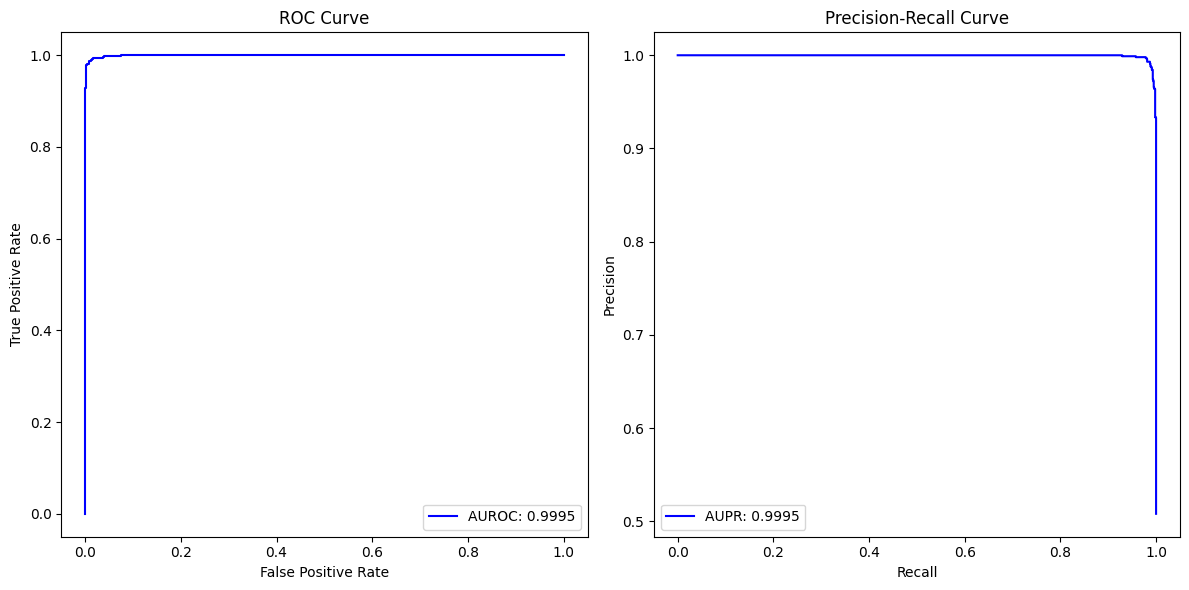

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.5835389571984609
Epoch [1/2000], Val Loss: 0.51370294547081
Epoch [2/2000], Train Loss: 0.3975207444826762
Epoch [2/2000], Val Loss: 0.33622939145565034
Epoch [3/2000], Train Loss: 0.2531968462417523
Epoch [3/2000], Val Loss: 0.3625238251984119
Epoch [4/2000], Train Loss: 0.2056403903067112
Epoch [4/2000], Val Loss: 0.24737775486707686
Epoch [5/2000], Train Loss: 0.14888903479774793
Epoch [5/2000], Val Loss: 0.2531968605220318
Epoch [6/2000], Train Loss: 0.1332533559948206
Epoch [6/2000], Val Loss: 0.21585350864566863
Epoch [7/2000], Train Loss: 0.10836373477677504
Epoch [7/2000], Val Loss: 0.22493449772894383
Epoch [8/2000], Train Loss: 0.10152598742519815
Epoch [8/2000], Val Loss: 0.2108014324065298
Epoch [9/2000], Train Loss: 0.1083575014087061
Epoch [9/2000], Val Loss: 0.23162377304956316
Epoch [10/2000], Train Loss: 0.08226394166409348
Epoch [10/2000], Val Loss: 0.23615983495349063
Epoch [11/2000], Tr

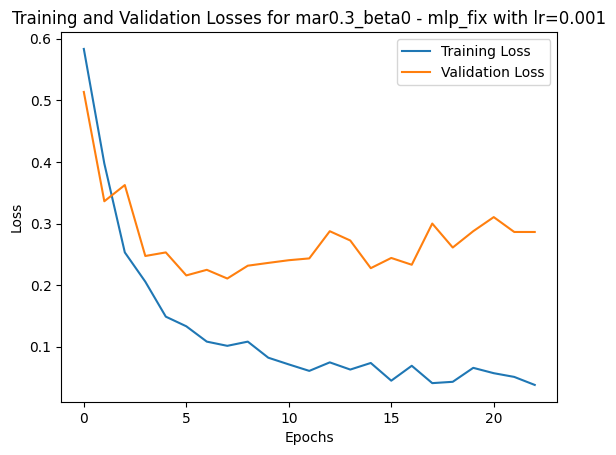

C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_mlp_fix_mar0.3_beta0_lr0.0001_lr0.001.pt


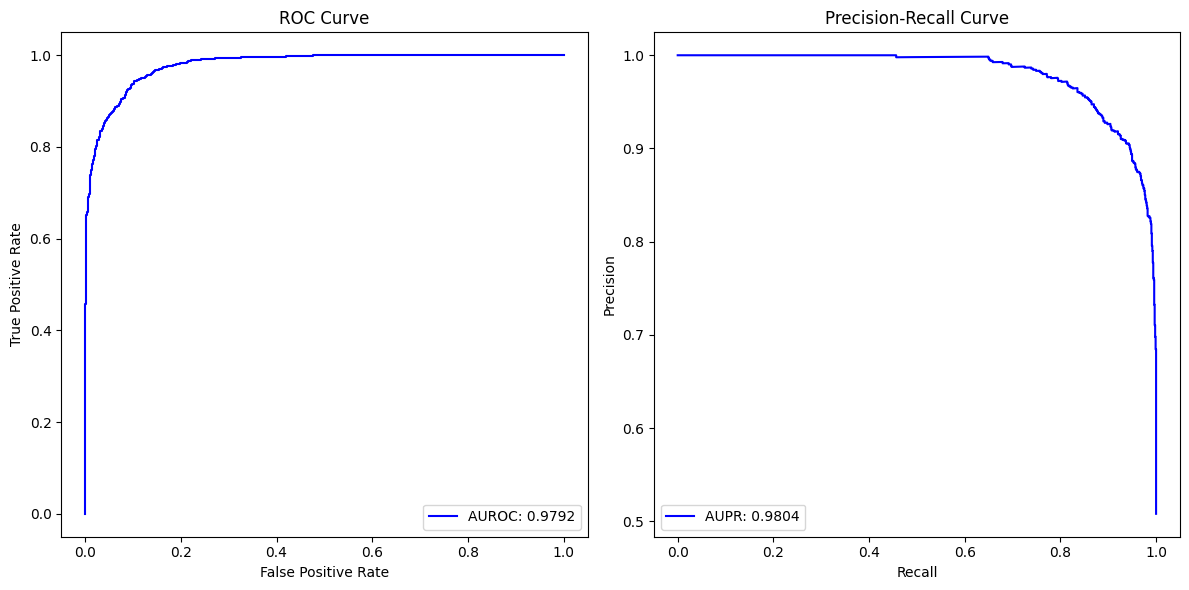

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6573730398019155
Epoch [1/2000], Val Loss: 0.6184027209281922
Epoch [2/2000], Train Loss: 0.5587791308561961
Epoch [2/2000], Val Loss: 0.5084877706766129
Epoch [3/2000], Train Loss: 0.4634697381655375
Epoch [3/2000], Val Loss: 0.4720149691104889
Epoch [4/2000], Train Loss: 0.3782758539915085
Epoch [4/2000], Val Loss: 0.42875850772857665
Epoch [5/2000], Train Loss: 0.32332932408650716
Epoch [5/2000], Val Loss: 0.4383545069694519
Epoch [6/2000], Train Loss: 0.2739141215880712
Epoch [6/2000], Val Loss: 0.4566317792534828
Epoch [7/2000], Train Loss: 0.2397074624200662
Epoch [7/2000], Val Loss: 0.5023410165905953
Epoch [8/2000], Train Loss: 0.2119279250552257
Epoch [8/2000], Val Loss: 0.5128274203538895
Epoch [9/2000], Train Loss: 0.18670463280379773
Epoch [9/2000], Val Loss: 0.5020455652475357
Epoch [10/2000], Train Loss: 0.15874183344344298
Epoch [10/2000], Val Loss: 0.46163595670461655
Epoch [11/2000], Train

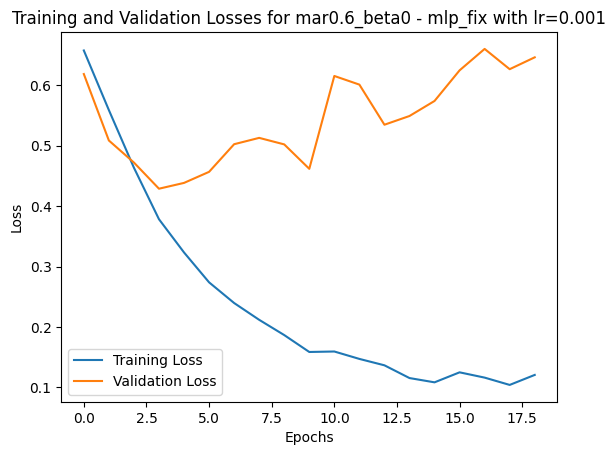

C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_mlp_fix_mar0.6_beta0_lr0.0001_lr0.001.pt


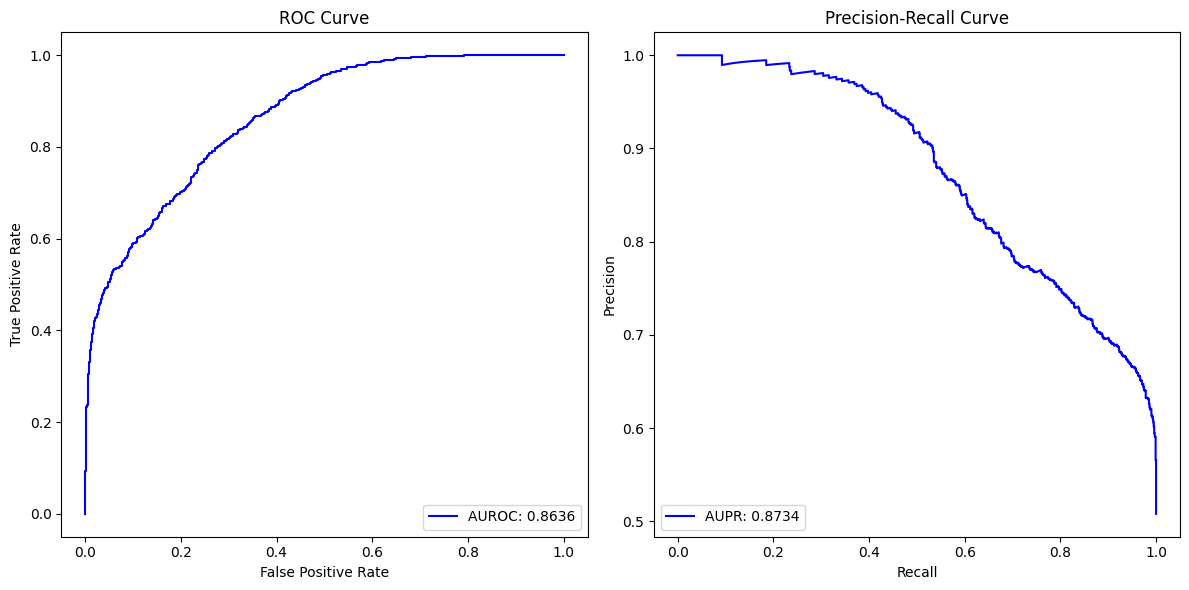

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.5630440512895584
Epoch [1/2000], Val Loss: 0.47907945382595063
Epoch [2/2000], Train Loss: 0.3586905658841133
Epoch [2/2000], Val Loss: 0.3660187707543373
Epoch [3/2000], Train Loss: 0.24950906758507094
Epoch [3/2000], Val Loss: 0.2656426650285721
Epoch [4/2000], Train Loss: 0.19221163469552993
Epoch [4/2000], Val Loss: 0.21220470386743545
Epoch [5/2000], Train Loss: 0.14417148326834042
Epoch [5/2000], Val Loss: 0.8703235704898834
Epoch [6/2000], Train Loss: 0.1342887210144351
Epoch [6/2000], Val Loss: 0.17835656441748143
Epoch [7/2000], Train Loss: 0.09922849213021497
Epoch [7/2000], Val Loss: 0.16659571185335517
Epoch [8/2000], Train Loss: 0.0930672416916738
Epoch [8/2000], Val Loss: 0.165722207326442
Epoch [9/2000], Train Loss: 0.08122721506857003
Epoch [9/2000], Val Loss: 0.21345863695442677
Epoch [10/2000], Train Loss: 0.07338009324499095
Epoch [10/2000], Val Loss: 0.21673762642219663
Epoch [11/2000],

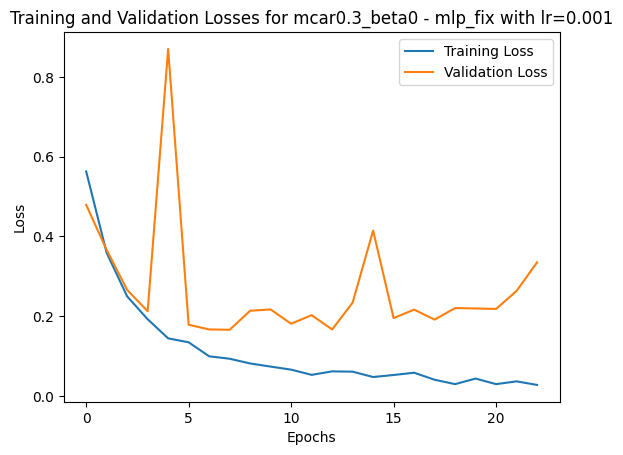

Model loaded from outputs/baseline_mlp_fix_mcar0.3_beta0_lr0.0001_lr0.001.pt


C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

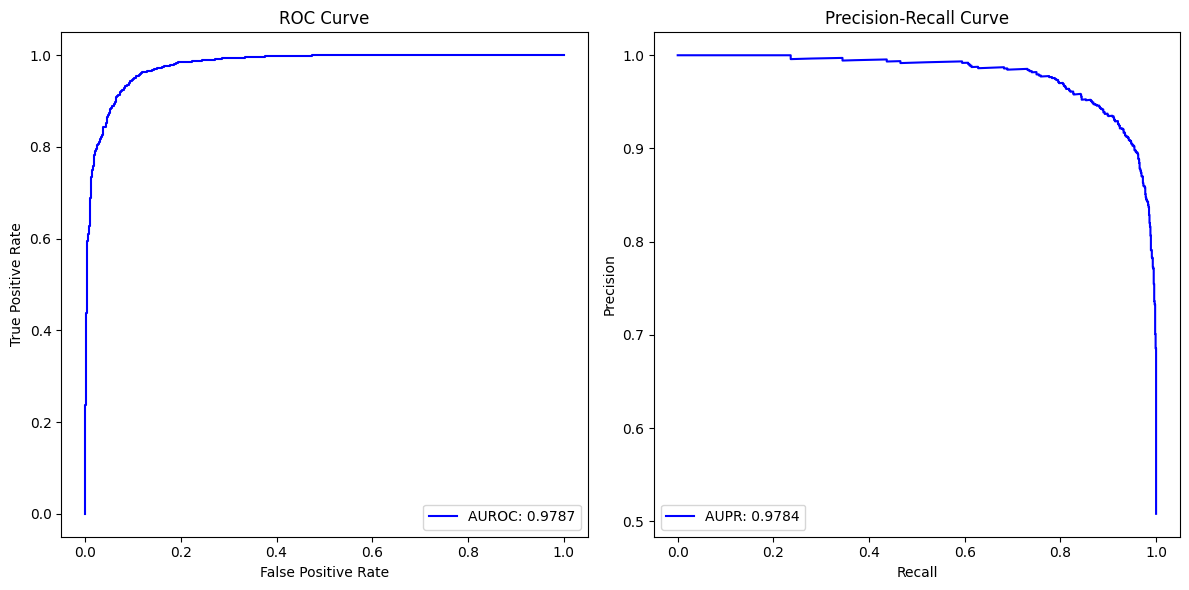

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6515892028808594
Epoch [1/2000], Val Loss: 0.6235443675518035
Epoch [2/2000], Train Loss: 0.5502105417251587
Epoch [2/2000], Val Loss: 0.49704619073867795
Epoch [3/2000], Train Loss: 0.39844100868701937
Epoch [3/2000], Val Loss: 0.4249281370639801
Epoch [4/2000], Train Loss: 0.3038140823642413
Epoch [4/2000], Val Loss: 0.3916025689840317
Epoch [5/2000], Train Loss: 0.25025692996382715
Epoch [5/2000], Val Loss: 0.3867269914150238
Epoch [6/2000], Train Loss: 0.20951501980423928
Epoch [6/2000], Val Loss: 0.42228115141391753
Epoch [7/2000], Train Loss: 0.18236581473549207
Epoch [7/2000], Val Loss: 0.40006849414110185
Epoch [8/2000], Train Loss: 0.15892162834107876
Epoch [8/2000], Val Loss: 0.41999243819713594
Epoch [9/2000], Train Loss: 0.13641191278522213
Epoch [9/2000], Val Loss: 0.38733553501963613
Epoch [10/2000], Train Loss: 0.11406752615670362
Epoch [10/2000], Val Loss: 0.3932098879516125
Epoch [11/2000]

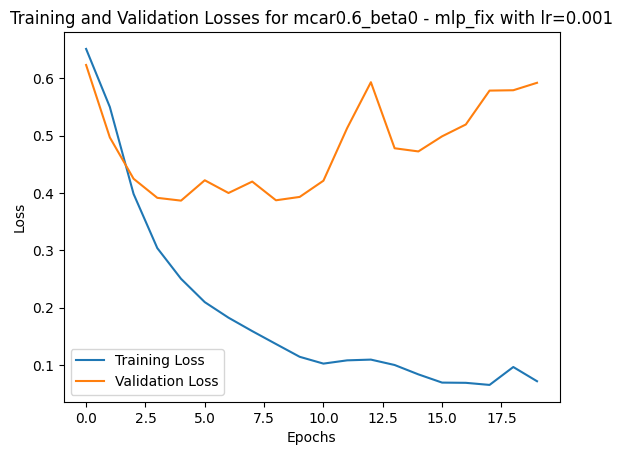

C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_mlp_fix_mcar0.6_beta0_lr0.0001_lr0.001.pt


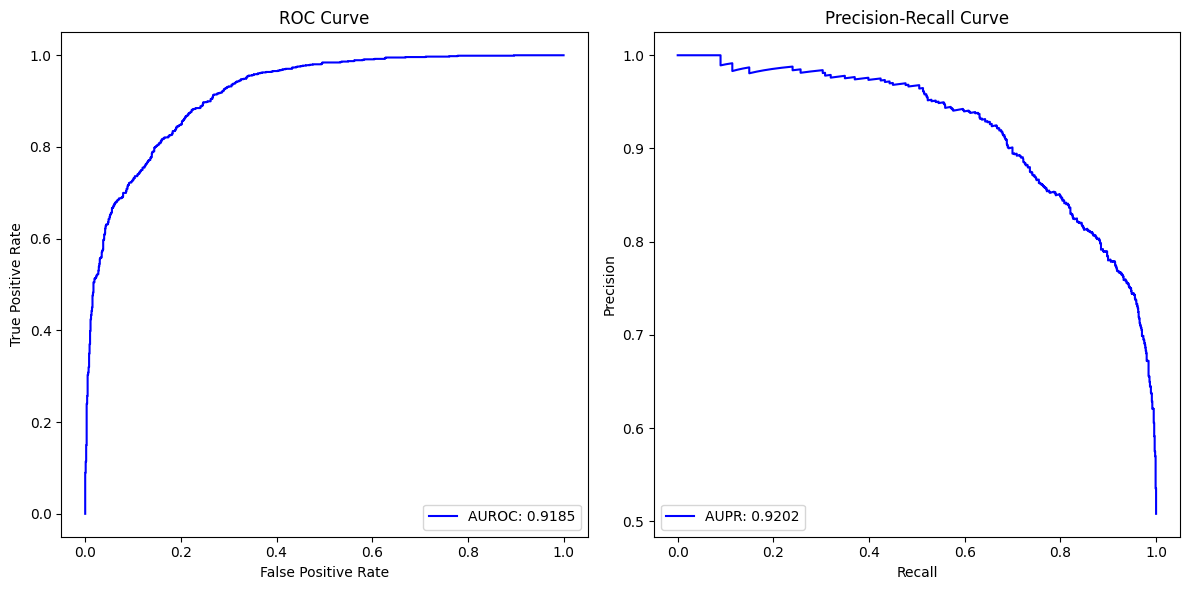

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.5711487364768982
Epoch [1/2000], Val Loss: 0.4817251869440079
Epoch [2/2000], Train Loss: 0.3928341250419617
Epoch [2/2000], Val Loss: 0.4509979914426804
Epoch [3/2000], Train Loss: 0.27793397205074627
Epoch [3/2000], Val Loss: 0.367102282166481
Epoch [4/2000], Train Loss: 0.22535131868720054
Epoch [4/2000], Val Loss: 0.23520902451872824
Epoch [5/2000], Train Loss: 0.19032700103521347
Epoch [5/2000], Val Loss: 0.2152925527393818
Epoch [6/2000], Train Loss: 0.1505110972772042
Epoch [6/2000], Val Loss: 0.2209693895801902
Epoch [7/2000], Train Loss: 0.123678798434635
Epoch [7/2000], Val Loss: 0.20427383679896594
Epoch [8/2000], Train Loss: 0.09761596826588115
Epoch [8/2000], Val Loss: 0.34858998645842076
Epoch [9/2000], Train Loss: 0.11081352339250346
Epoch [9/2000], Val Loss: 0.21226503278315068
Epoch [10/2000], Train Loss: 0.07202030551557739
Epoch [10/2000], Val Loss: 0.1739159548431635
Epoch [11/2000], Tr

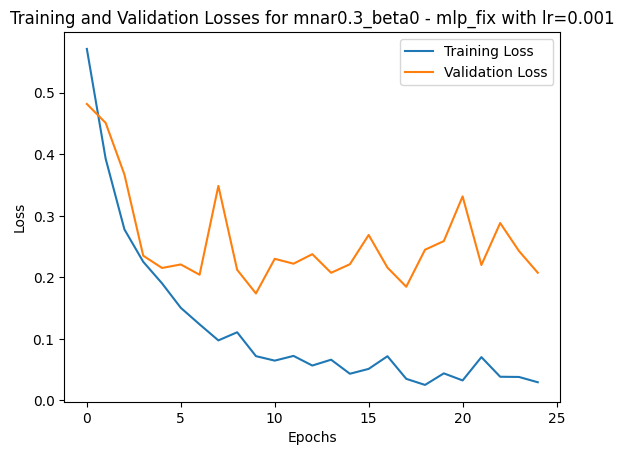

C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_mlp_fix_mnar0.3_beta0_lr0.0001_lr0.001.pt


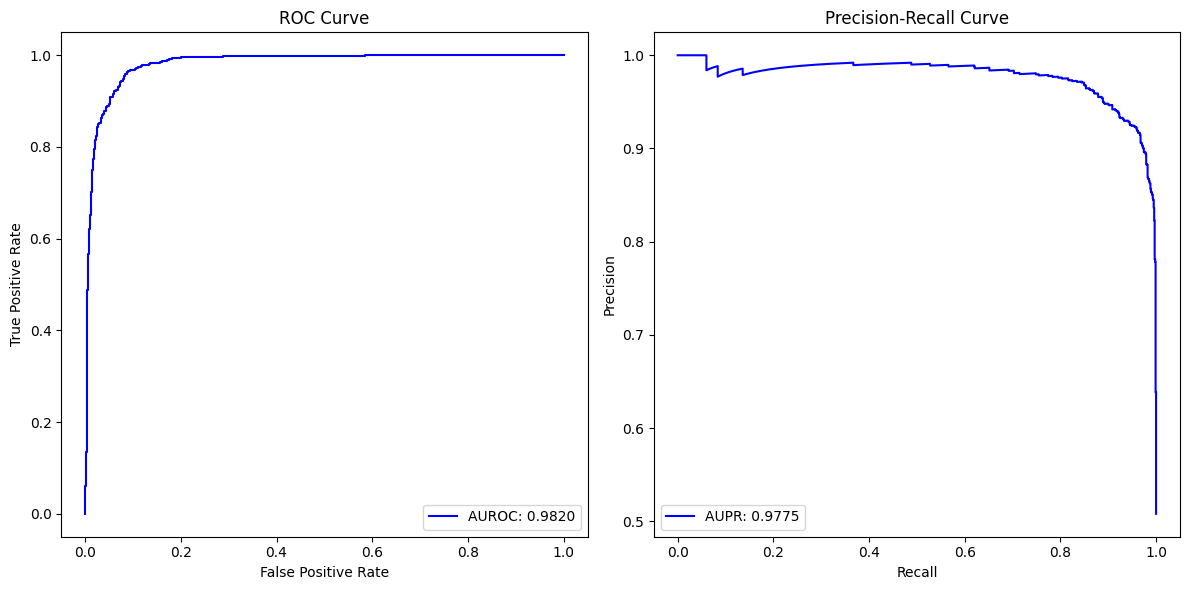

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6577096967697144
Epoch [1/2000], Val Loss: 0.621567456960678
Epoch [2/2000], Train Loss: 0.5772638192971548
Epoch [2/2000], Val Loss: 0.5280914270877838
Epoch [3/2000], Train Loss: 0.44254559743404387
Epoch [3/2000], Val Loss: 0.5035818583965301
Epoch [4/2000], Train Loss: 0.35768438545862835
Epoch [4/2000], Val Loss: 0.40996169316768644
Epoch [5/2000], Train Loss: 0.30553786613543826
Epoch [5/2000], Val Loss: 0.39460553938150406
Epoch [6/2000], Train Loss: 0.2559412440756957
Epoch [6/2000], Val Loss: 0.39418166524171827
Epoch [7/2000], Train Loss: 0.21651325792074202
Epoch [7/2000], Val Loss: 0.44310769155621527
Epoch [8/2000], Train Loss: 0.20813484595716
Epoch [8/2000], Val Loss: 0.4165930579900742
Epoch [9/2000], Train Loss: 0.1712114275197188
Epoch [9/2000], Val Loss: 0.39473035544157026
Epoch [10/2000], Train Loss: 0.1584879135377705
Epoch [10/2000], Val Loss: 0.40883797672390937
Epoch [11/2000], Tra

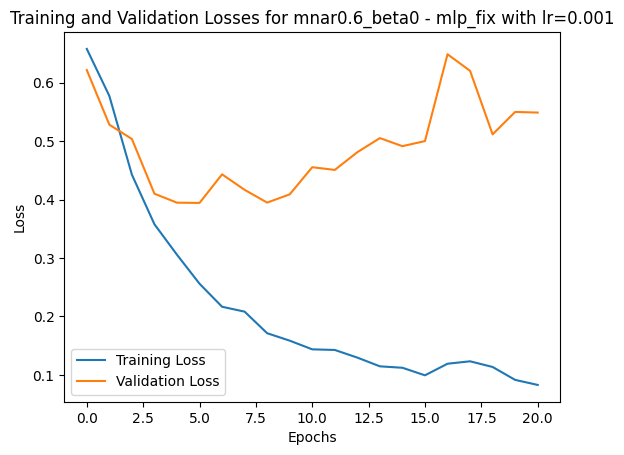

C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_mlp_fix_mnar0.6_beta0_lr0.0001_lr0.001.pt


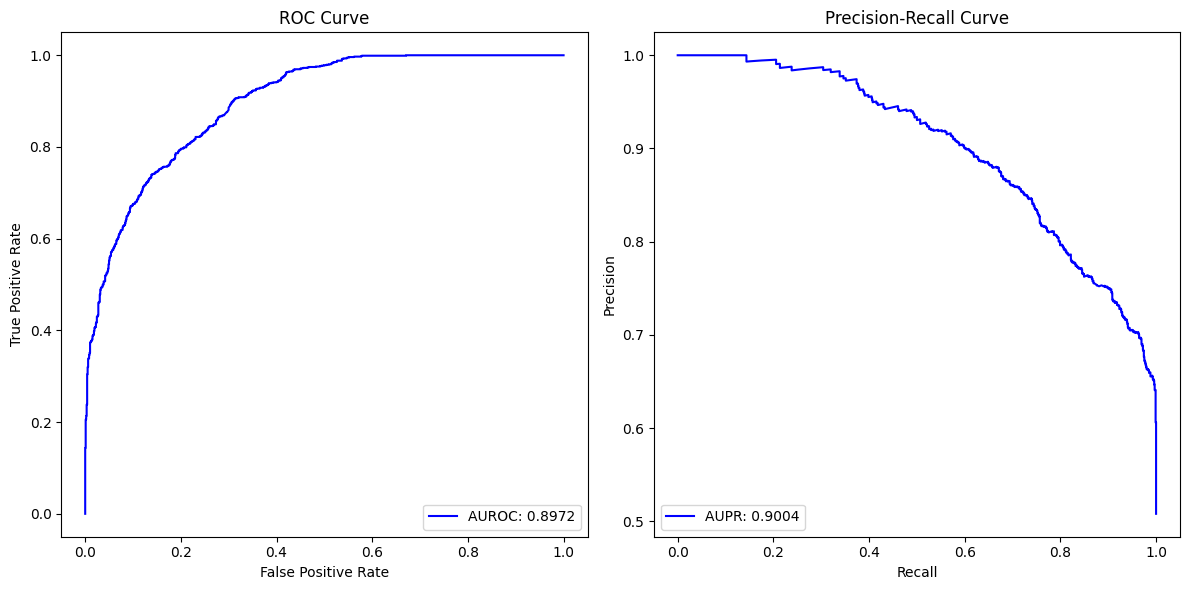

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.189405553145955
Epoch [1/2000], Val Loss: 0.05530752032902092
Epoch [2/2000], Train Loss: 0.05852170240351309
Epoch [2/2000], Val Loss: 0.04496323618898168
Epoch [3/2000], Train Loss: 0.05227940358128399
Epoch [3/2000], Val Loss: 0.05133215159829706
Epoch [4/2000], Train Loss: 0.04654371644960095
Epoch [4/2000], Val Loss: 0.05635287517029792
Epoch [5/2000], Train Loss: 0.042550228011755585
Epoch [5/2000], Val Loss: 0.03971733982977457
Epoch [6/2000], Train Loss: 0.04232312728984592
Epoch [6/2000], Val Loss: 0.037117532409494745
Epoch [7/2000], Train Loss: 0.049800936369613434
Epoch [7/2000], Val Loss: 0.09713891684194095
Epoch [8/2000], Train Loss: 0.03677445952423538
Epoch [8/2000], Val Loss: 0.05675013637752272
Epoch [9/2000], Train Loss: 0.04115158044290729
Epoch [9/2000], Val Loss: 0.03833633240289055
Epoch [10/2000], Train Loss: 0.05137428223582295
Epoch [10/2000], Val Loss: 0.045619223326910284
Epoch

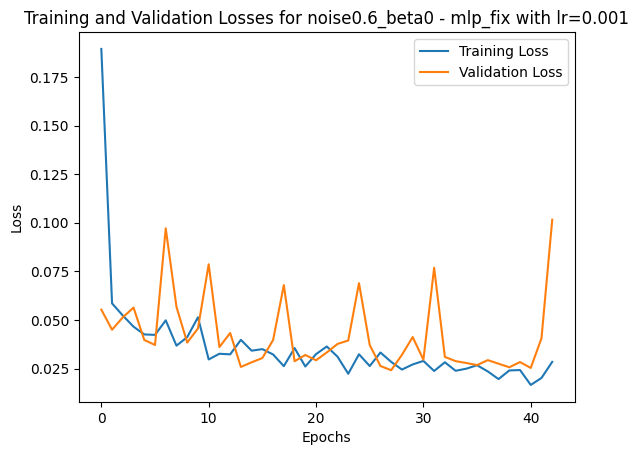

C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_mlp_fix_noise0.6_beta0_lr0.0001_lr0.001.pt


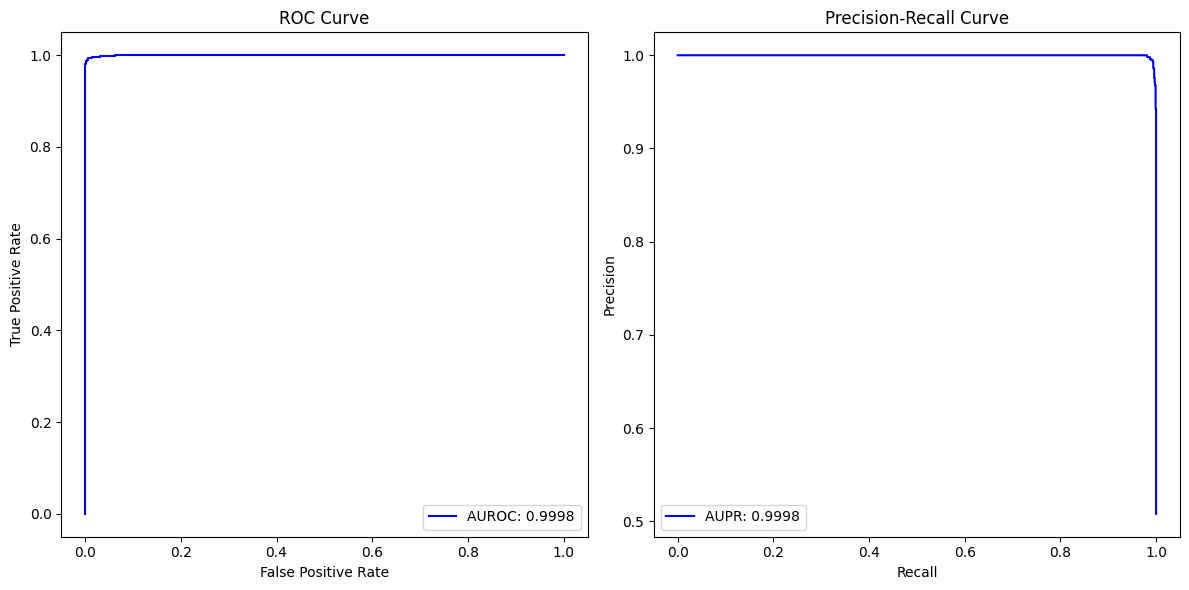

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6811634788513183
Epoch [1/2000], Val Loss: 0.6711575131416321
Epoch [2/2000], Train Loss: 0.6692834397951762
Epoch [2/2000], Val Loss: 0.6638436431884766
Epoch [3/2000], Train Loss: 0.6618050473531087
Epoch [3/2000], Val Loss: 0.656787416934967
Epoch [4/2000], Train Loss: 0.6551445476214091
Epoch [4/2000], Val Loss: 0.6519576678276062
Epoch [5/2000], Train Loss: 0.6501450748443603
Epoch [5/2000], Val Loss: 0.6476151013374328
Epoch [6/2000], Train Loss: 0.6454643885294596
Epoch [6/2000], Val Loss: 0.6443221986293792
Epoch [7/2000], Train Loss: 0.6416751681963603
Epoch [7/2000], Val Loss: 0.6405578260421753
Epoch [8/2000], Train Loss: 0.6383895530700684
Epoch [8/2000], Val Loss: 0.6378159260749817
Epoch [9/2000], Train Loss: 0.6354018553892772
Epoch [9/2000], Val Loss: 0.6351765413284302
Epoch [10/2000], Train Loss: 0.6328961378733317
Epoch [10/2000], Val Loss: 0.6330042049884796
Epoch [11/2000], Train Loss:

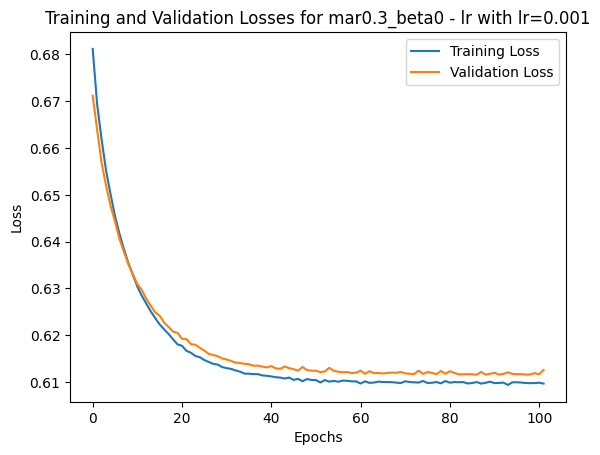

C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_lr_mar0.3_beta0_lr0.0001_lr0.001.pt


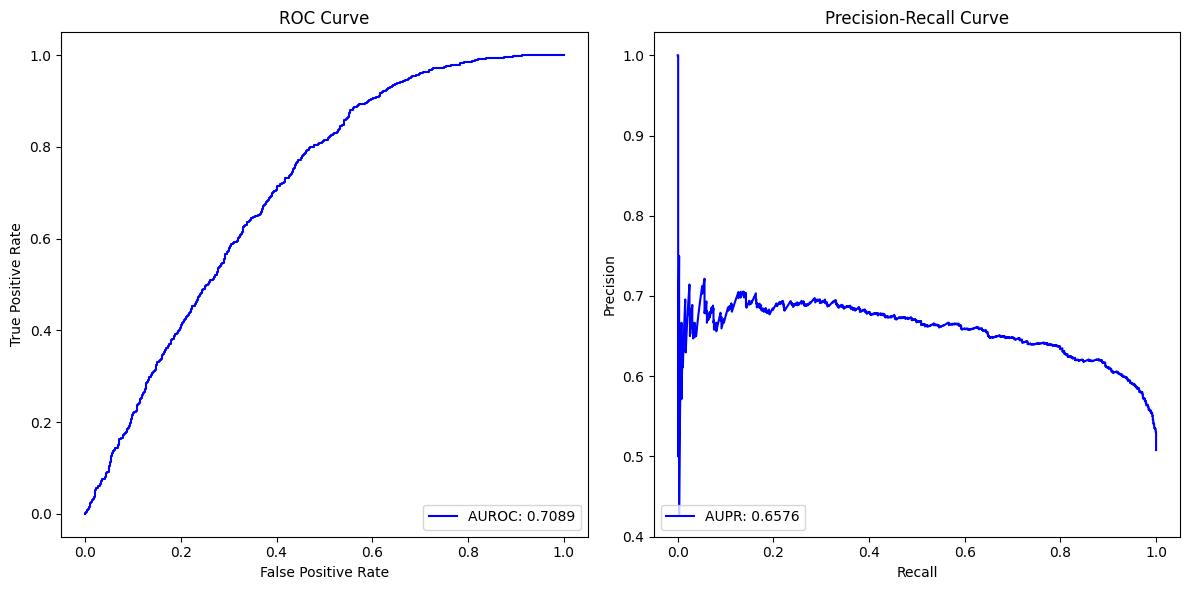

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6859926805496216
Epoch [1/2000], Val Loss: 0.6822710165977478
Epoch [2/2000], Train Loss: 0.6797634315490723
Epoch [2/2000], Val Loss: 0.6777223901748657
Epoch [3/2000], Train Loss: 0.6762353922526042
Epoch [3/2000], Val Loss: 0.6750999917984009
Epoch [4/2000], Train Loss: 0.6738905986150105
Epoch [4/2000], Val Loss: 0.6737819600105286
Epoch [5/2000], Train Loss: 0.6721948808034262
Epoch [5/2000], Val Loss: 0.6727120547294617
Epoch [6/2000], Train Loss: 0.6708941025733948
Epoch [6/2000], Val Loss: 0.6723369765281677
Epoch [7/2000], Train Loss: 0.6700274276733399
Epoch [7/2000], Val Loss: 0.671616400718689
Epoch [8/2000], Train Loss: 0.6694175914128622
Epoch [8/2000], Val Loss: 0.6712206282615661
Epoch [9/2000], Train Loss: 0.6687236776351929
Epoch [9/2000], Val Loss: 0.6711375656127929
Epoch [10/2000], Train Loss: 0.6682740254402161
Epoch [10/2000], Val Loss: 0.6711219749450683
Epoch [11/2000], Train Loss:

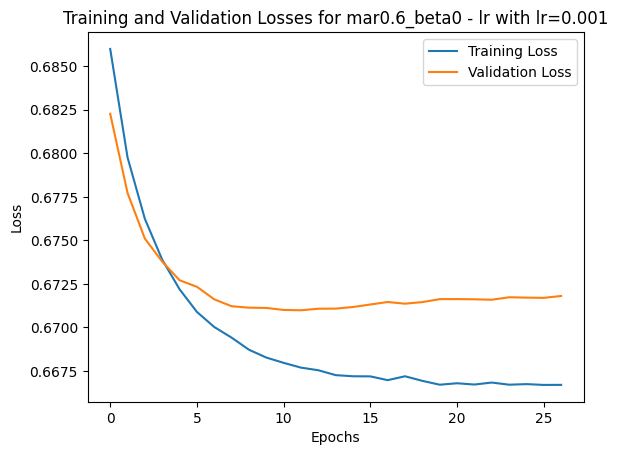

Model loaded from outputs/baseline_lr_mar0.6_beta0_lr0.0001_lr0.001.pt


C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

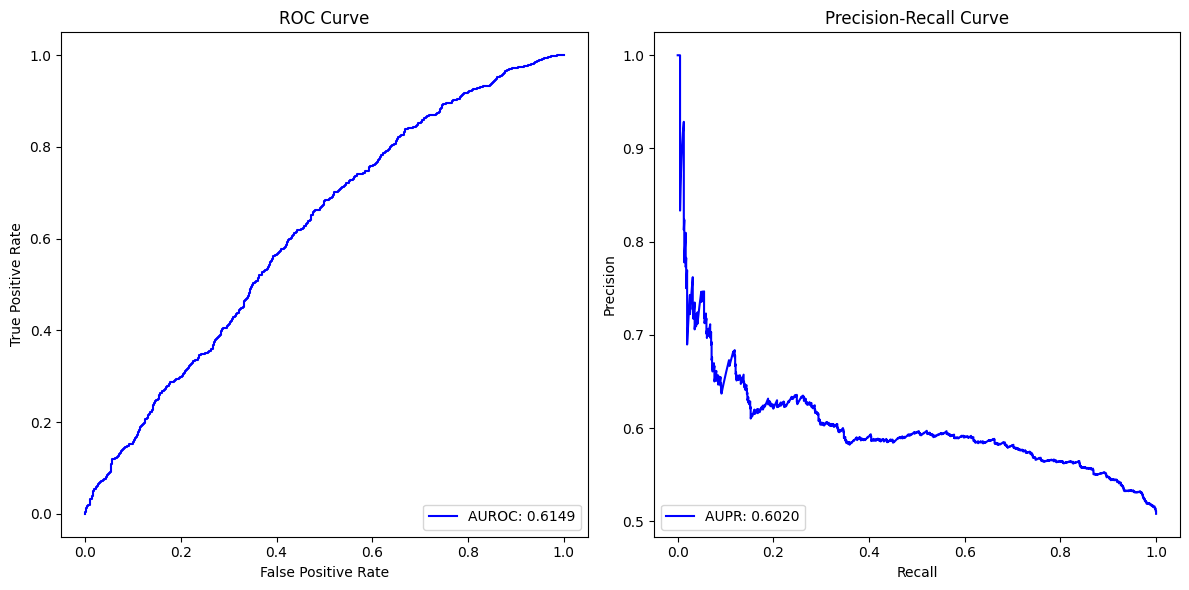

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6876002930005392
Epoch [1/2000], Val Loss: 0.6710154538154602
Epoch [2/2000], Train Loss: 0.6692058323224386
Epoch [2/2000], Val Loss: 0.6594243187904358
Epoch [3/2000], Train Loss: 0.6591781655947367
Epoch [3/2000], Val Loss: 0.6513212485313415
Epoch [4/2000], Train Loss: 0.6513813258806864
Epoch [4/2000], Val Loss: 0.6456364588737488
Epoch [5/2000], Train Loss: 0.644952265103658
Epoch [5/2000], Val Loss: 0.6403092904090881
Epoch [6/2000], Train Loss: 0.639316654920578
Epoch [6/2000], Val Loss: 0.6361510190963745
Epoch [7/2000], Train Loss: 0.6342185605367024
Epoch [7/2000], Val Loss: 0.6323618202209472
Epoch [8/2000], Train Loss: 0.6296388652324677
Epoch [8/2000], Val Loss: 0.6295467119216919
Epoch [9/2000], Train Loss: 0.6261023670832316
Epoch [9/2000], Val Loss: 0.6260084247589112
Epoch [10/2000], Train Loss: 0.6223750616709391
Epoch [10/2000], Val Loss: 0.6231305389404297
Epoch [11/2000], Train Loss: 

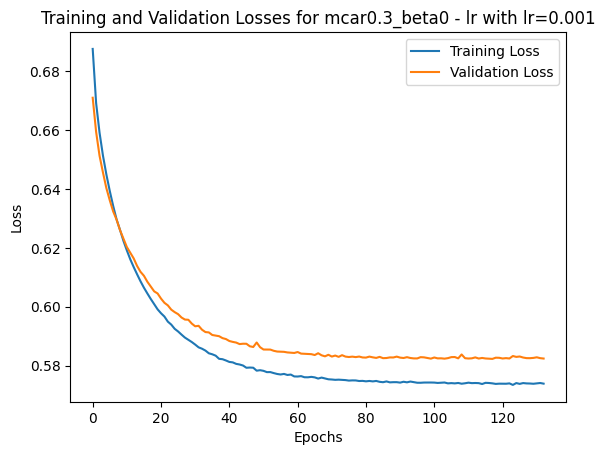

C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_lr_mcar0.3_beta0_lr0.0001_lr0.001.pt


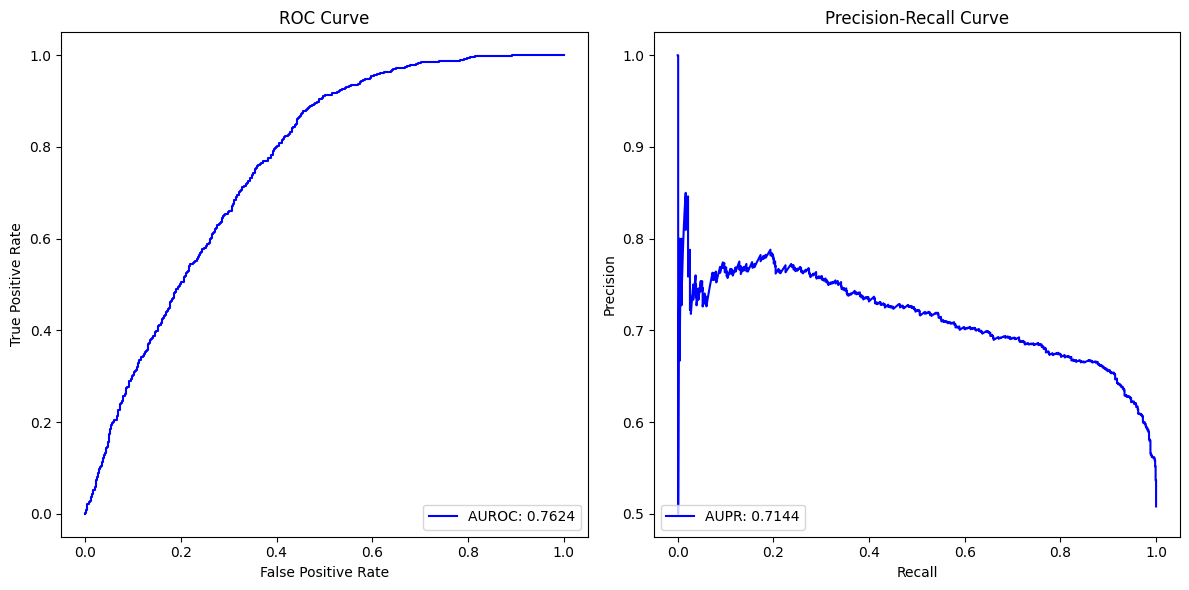

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6870302823384603
Epoch [1/2000], Val Loss: 0.6779099321365356
Epoch [2/2000], Train Loss: 0.6762389701207479
Epoch [2/2000], Val Loss: 0.6706261076927185
Epoch [3/2000], Train Loss: 0.6702572949727377
Epoch [3/2000], Val Loss: 0.6662065629959106
Epoch [4/2000], Train Loss: 0.666007774511973
Epoch [4/2000], Val Loss: 0.6629316534996033
Epoch [5/2000], Train Loss: 0.6626825119654337
Epoch [5/2000], Val Loss: 0.6606557569503784
Epoch [6/2000], Train Loss: 0.6600816109975179
Epoch [6/2000], Val Loss: 0.6587368097305298
Epoch [7/2000], Train Loss: 0.6578718296686809
Epoch [7/2000], Val Loss: 0.6572061433792115
Epoch [8/2000], Train Loss: 0.6560734589099884
Epoch [8/2000], Val Loss: 0.6558956007957458
Epoch [9/2000], Train Loss: 0.6545259545644124
Epoch [9/2000], Val Loss: 0.6547558450698853
Epoch [10/2000], Train Loss: 0.6530870043436686
Epoch [10/2000], Val Loss: 0.6539121217727661
Epoch [11/2000], Train Loss:

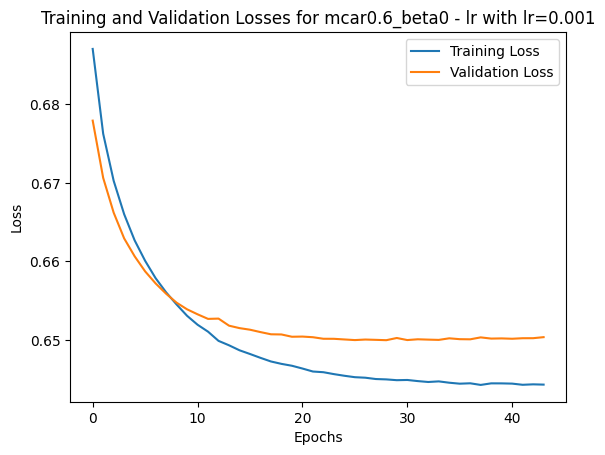

C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_lr_mcar0.6_beta0_lr0.0001_lr0.001.pt


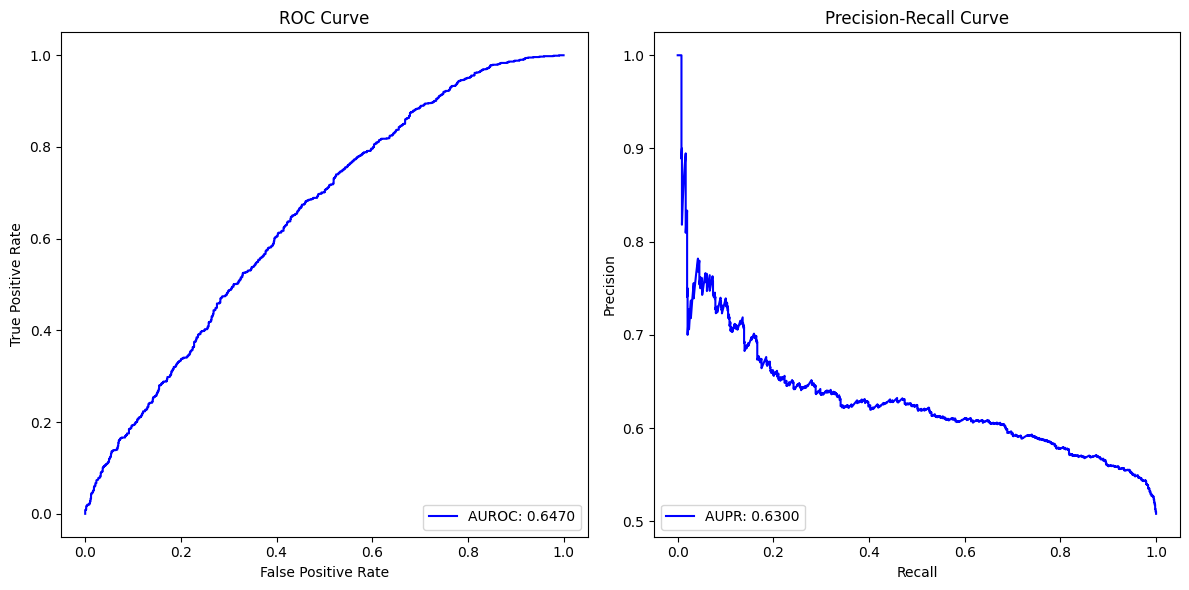

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6853600697517395
Epoch [1/2000], Val Loss: 0.672441819190979
Epoch [2/2000], Train Loss: 0.6697399671872457
Epoch [2/2000], Val Loss: 0.6619980521202088
Epoch [3/2000], Train Loss: 0.6603859105110168
Epoch [3/2000], Val Loss: 0.6543659567832947
Epoch [4/2000], Train Loss: 0.6527152477900188
Epoch [4/2000], Val Loss: 0.6482873547077179
Epoch [5/2000], Train Loss: 0.6465937304496765
Epoch [5/2000], Val Loss: 0.6434878845214844
Epoch [6/2000], Train Loss: 0.641101712067922
Epoch [6/2000], Val Loss: 0.6394369459152222
Epoch [7/2000], Train Loss: 0.6368693281809489
Epoch [7/2000], Val Loss: 0.6359260478019715
Epoch [8/2000], Train Loss: 0.6329892435868582
Epoch [8/2000], Val Loss: 0.6327935590744018
Epoch [9/2000], Train Loss: 0.6294851345221202
Epoch [9/2000], Val Loss: 0.6308841955661774
Epoch [10/2000], Train Loss: 0.6267859508196513
Epoch [10/2000], Val Loss: 0.6280306091308594
Epoch [11/2000], Train Loss: 

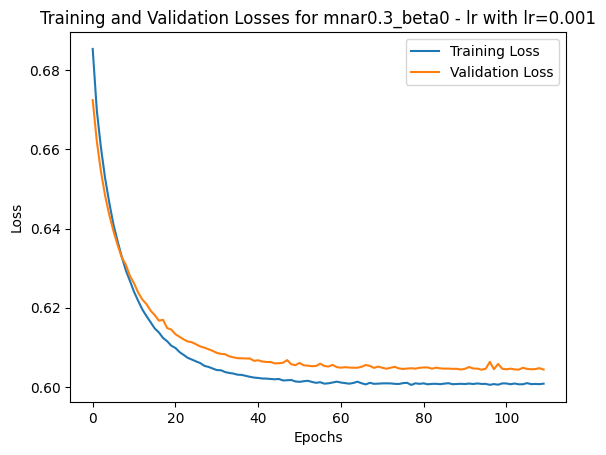

C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_lr_mnar0.3_beta0_lr0.0001_lr0.001.pt


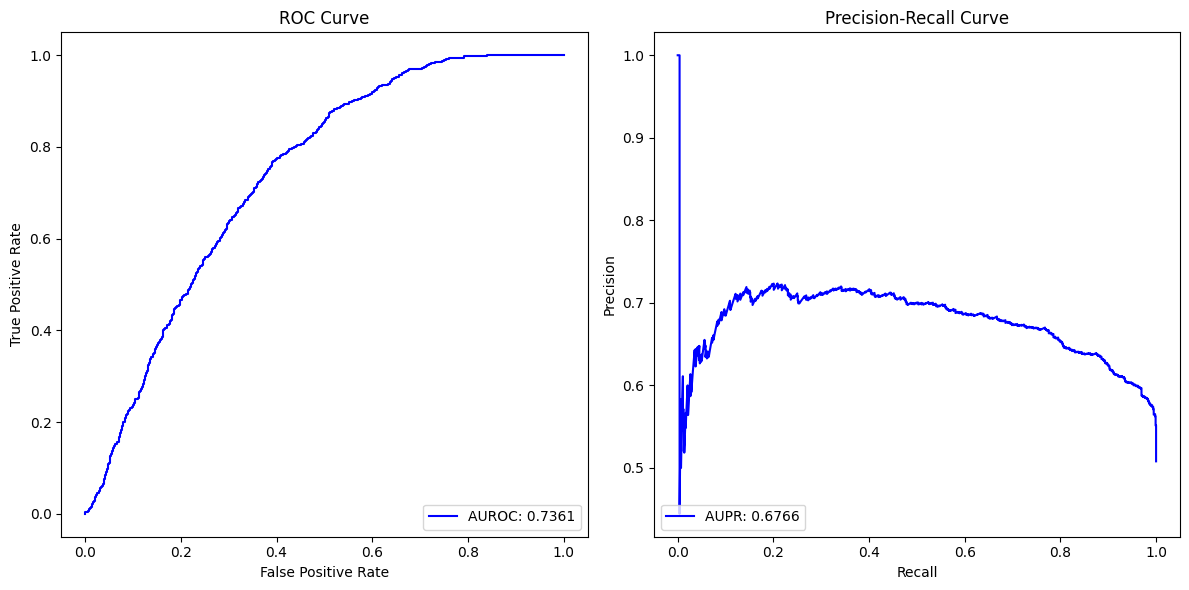

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6848992729187011
Epoch [1/2000], Val Loss: 0.6793383793830872
Epoch [2/2000], Train Loss: 0.677202863852183
Epoch [2/2000], Val Loss: 0.6741693587303161
Epoch [3/2000], Train Loss: 0.6723249980608622
Epoch [3/2000], Val Loss: 0.6710984025001526
Epoch [4/2000], Train Loss: 0.6692668690681457
Epoch [4/2000], Val Loss: 0.669255690574646
Epoch [5/2000], Train Loss: 0.6667883256276449
Epoch [5/2000], Val Loss: 0.6680188212394714
Epoch [6/2000], Train Loss: 0.6651876670519511
Epoch [6/2000], Val Loss: 0.6668685603141785
Epoch [7/2000], Train Loss: 0.6637670815785726
Epoch [7/2000], Val Loss: 0.6665581674575806
Epoch [8/2000], Train Loss: 0.6629724771181742
Epoch [8/2000], Val Loss: 0.6659881601333618
Epoch [9/2000], Train Loss: 0.6622182057698568
Epoch [9/2000], Val Loss: 0.6658192825317383
Epoch [10/2000], Train Loss: 0.6617515931129455
Epoch [10/2000], Val Loss: 0.6656879868507385
Epoch [11/2000], Train Loss: 

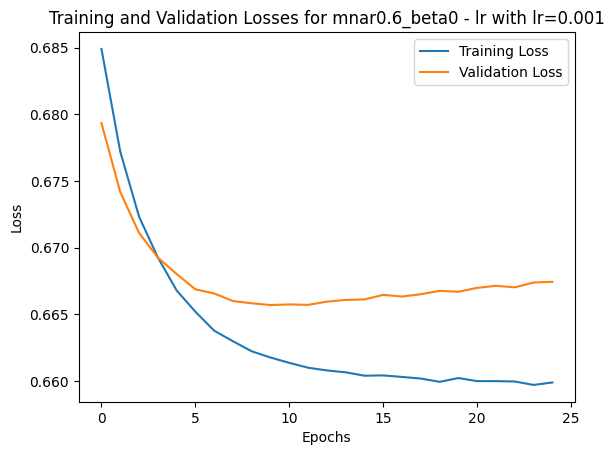

C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_lr_mnar0.6_beta0_lr0.0001_lr0.001.pt


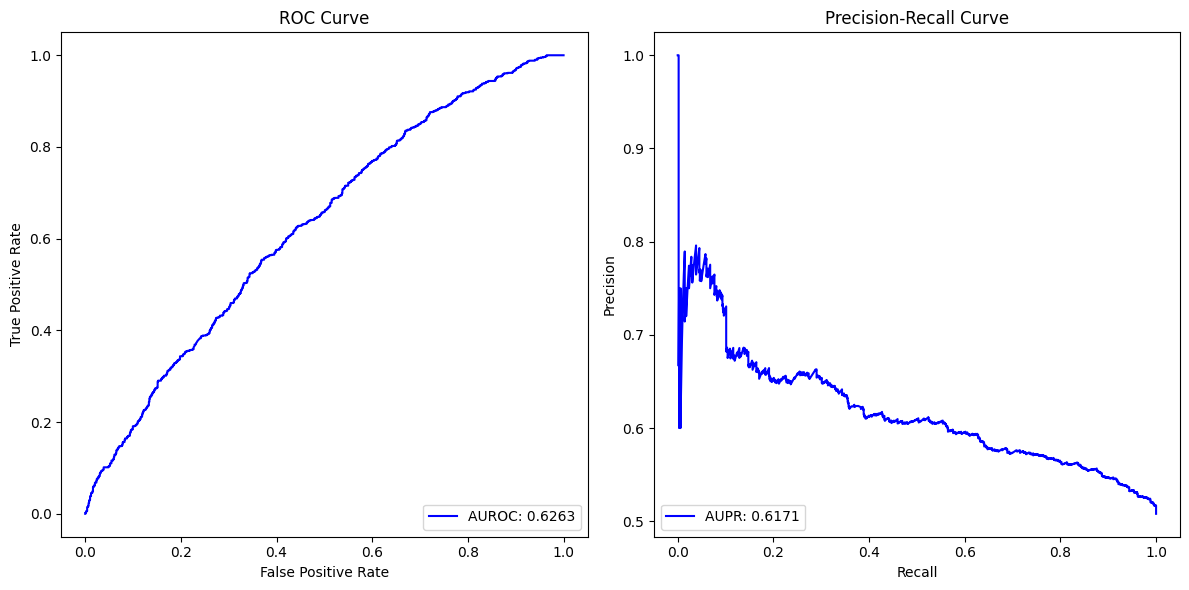

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6732970980008444
Epoch [1/2000], Val Loss: 0.659848087310791
Epoch [2/2000], Train Loss: 0.6534168658256531
Epoch [2/2000], Val Loss: 0.6437865200042725
Epoch [3/2000], Train Loss: 0.6393306004206339
Epoch [3/2000], Val Loss: 0.6323903183937073
Epoch [4/2000], Train Loss: 0.6268081510861715
Epoch [4/2000], Val Loss: 0.621155079126358
Epoch [5/2000], Train Loss: 0.6145394903818766
Epoch [5/2000], Val Loss: 0.6098157887458802
Epoch [6/2000], Train Loss: 0.6035260898272197
Epoch [6/2000], Val Loss: 0.5986666264533996
Epoch [7/2000], Train Loss: 0.5924491121768951
Epoch [7/2000], Val Loss: 0.5879976456165313
Epoch [8/2000], Train Loss: 0.5819771513144175
Epoch [8/2000], Val Loss: 0.577995750427246
Epoch [9/2000], Train Loss: 0.5716787156263987
Epoch [9/2000], Val Loss: 0.5680744280815124
Epoch [10/2000], Train Loss: 0.5613591050306956
Epoch [10/2000], Val Loss: 0.5587671809196472
Epoch [11/2000], Train Loss: 0

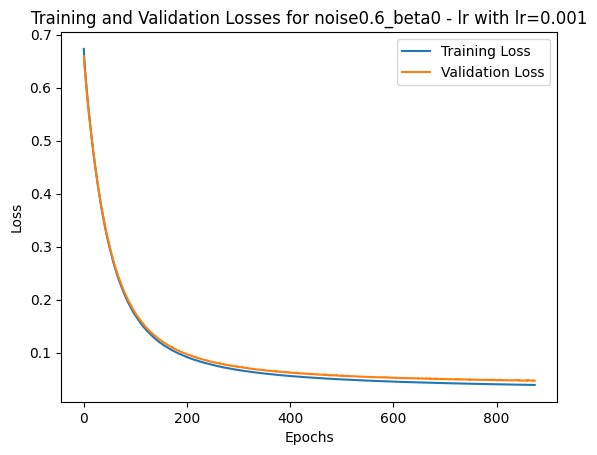

C:\Users\kr3164\AppData\Local\Temp\ipykernel_19400\531705114.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_lr_noise0.6_beta0_lr0.0001_lr0.001.pt


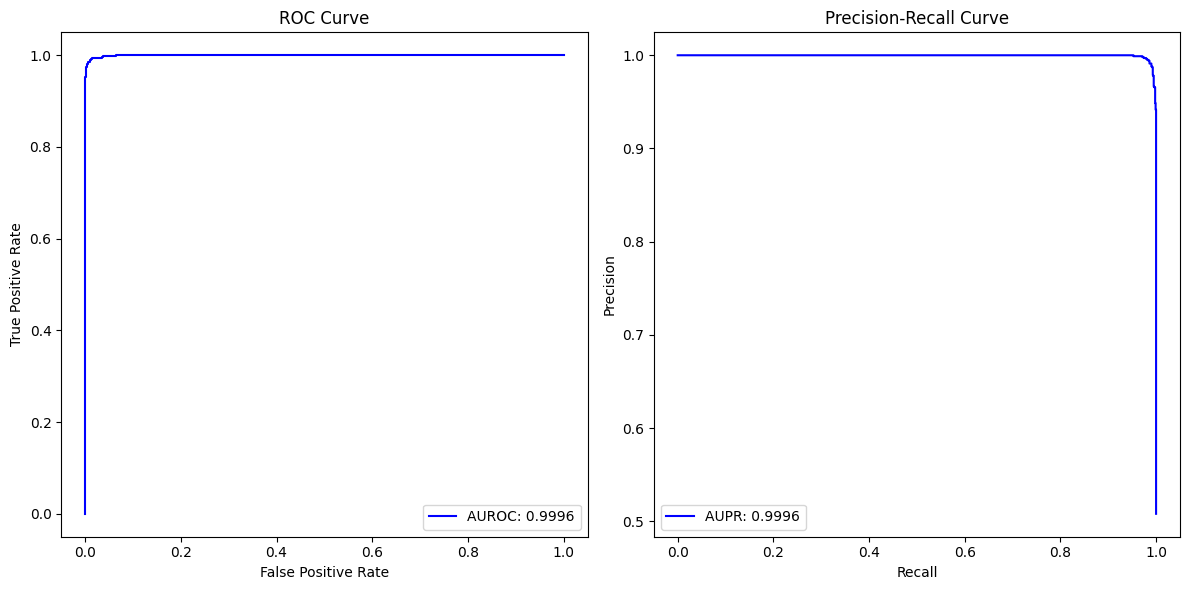

In [30]:
import torch
from training import Training

import random
import os

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Set the device for PyTorch (use 'cuda' for GPU if available)
device = torch.device('cpu')  # Change to 'cuda' if using GPU
random.seed(111)
# Define lists for model configurations you want to try
model_names = ['mlp_fix','lr']  # List of model names/configurations
annotations = ['_lr0.0001']  # List of annotations to distinguish model variants
learning_rates = [0.0001,0.001]  # List of learning rates to try

# Define model parameters (modify as per your requirements)
input_dim = 49
hidden_dim = 1536

# Loop through each learning rate, model configuration, and dataset
for lr in learning_rates:
    for model_name in model_names:
        for add_annot in annotations:
            for filename in os.listdir('datasets_new_scenarios'):
                if filename.endswith('.pickle'):
                    # Extract the dataset name without the file extension
                    name = filename.replace('.pickle', '')

                    # Load the dataset
                    with open(f'datasets_new_scenarios/{name}.pickle', 'rb') as handle:
                        trends_data = pickle.load(handle)

                    # Initialize the Training class with specified parameters
                    training = Training(
                        trends_data,
                        model=model_name,
                        input_dim=input_dim,
                        hidden_dim=hidden_dim,
                        device=device,
                        dropout= 0.5
                    )

                    # Run the training process with the specified learning rate
                    best_model, train_loss, val_loss = training.training(lr=lr,l1_lambda=0,weight_decay=0.000)  # Pass the learning rate here

                    # Define paths for saving model and loss data
                    model_save_path = f'outputs/baseline_{model_name}_{name}{add_annot}_lr{lr}.pt'
                    train_loss_save_path = f'outputs/train_losses_{model_name}_{name}{add_annot}_lr{lr}.pickle'
                    val_loss_save_path = f'outputs/val_losses_{model_name}_{name}{add_annot}_lr{lr}.pickle'

                    # Save the trained model
                    try:
                        torch.save(best_model, model_save_path)
                        print(f"Model saved as {model_save_path}")
                    except Exception as e:
                        print(f"Error saving model: {e}")

                    # Save training and validation losses
                    with open(train_loss_save_path, 'wb') as handle:
                        pickle.dump(train_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
                    print(f"Training losses saved as {train_loss_save_path}")

                    with open(val_loss_save_path, 'wb') as handle:
                        pickle.dump(val_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
                    print(f"Validation losses saved as {val_loss_save_path}")

                    # Plot training and validation losses
                    plt.plot(train_loss, label='Training Loss')
                    plt.plot(val_loss, label='Validation Loss')
                    plt.xlabel('Epochs')
                    plt.ylabel('Loss')
                    plt.legend(['Training Loss', 'Validation Loss'])
                    plt.title(f'Training and Validation Losses for {name} - {model_name} with lr={lr}')
                    plt.show()

                    # Initialize the test loader and load the trained model
                    test_loader = training.data_splits.test_loader
                    model = training.model

                    # Load the trained model state if it exists
                    if os.path.exists(model_save_path):
                        try:
                            model.load_state_dict(torch.load(model_save_path, map_location=device))
                            print(f"Model loaded from {model_save_path}")
                        except Exception as e:
                            print(f"Error loading model: {e}")
                    else:
                        print(f"Model file not found: {model_save_path}")

                    # Function to create a padding mask
                    def create_padding_mask(seq_lengths, max_len):
                        batch_size = len(seq_lengths)
                        mask = torch.zeros(batch_size, max_len, dtype=torch.bool)
                        for i, seq_len in enumerate(seq_lengths):
                            mask[i, seq_len:] = True
                        return mask

                    # Evaluate the model
                    model.eval()
                    all_outputs, all_labels = [], []
                    with torch.no_grad():
                        for sequences, labels in test_loader:
                            sequences, labels = sequences.to(device), labels.float().to(device)
                            seq_lengths = [len(seq[seq != 0]) for seq in sequences]
                            max_len = sequences.size(1)
                            mask = create_padding_mask(seq_lengths, max_len).to(device)
                            outputs = model(sequences, mask)
                            all_outputs.extend(outputs.detach().cpu().numpy())
                            all_labels.extend(labels.detach().cpu().numpy())

                    # Function to plot ROC and PR curves
                    def roc_pr(outputs, labels, plot='no'):
                        fpr, tpr, _ = roc_curve(np.array(labels), np.array(outputs))
                        pre, rec, _ = precision_recall_curve(np.array(labels), np.array(outputs))

                        if plot == 'yes':
                            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
                            roc_auc = auc(fpr, tpr)
                            ax1.plot(fpr, tpr, color='b', label=f'AUROC: {roc_auc:.4f}')
                            pr_auc = auc(rec, pre)
                            ax2.plot(rec, pre, color='b', label=f'AUPR: {pr_auc:.4f}')
                            ax1.set_title('ROC Curve')
                            ax1.set_xlabel('False Positive Rate')
                            ax1.set_ylabel('True Positive Rate')
                            ax1.legend(loc="lower right")
                            ax2.set_title('Precision-Recall Curve')
                            ax2.set_xlabel('Recall')
                            ax2.set_ylabel('Precision')
                            ax2.legend(loc="lower left")
                            plt.tight_layout()
                            plt.show()

                    # Plot ROC and PR curves
                    roc_pr(all_outputs, all_labels, plot='yes')
